# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.simplefilter('always', category=UserWarning)
sns.set_theme()

# Dataframe

In [3]:
df = pd.read_csv("../artifacts/dataset.csv")

In [4]:
df.head()

patient_id                    main_diagnosis type_of_care_discharge_needed  \
0           0       Heart failure (ICD-10: I50)                     home care   
1           1  Acute appendicitis (ICD-10: K35)                           NaN   
2           2              Asthma (ICD-10: J45)                           NaN   
3           3     Lower back pain (ICD-10: M54)                           NaN   
4           4       Heart failure (ICD-10: I50)    short term stationary care   

  care_level blood_pressure_at_admission  heart_rate_at_admission  \
0          3                      120/80                       82   
1          3                      120/80                       63   
2          4                      130/85                       86   
3          4                      140/90                       77   
4    unknown                      120/80                       80   

   temperature_at_admission   gender  \
0                      36.5   female   
1                      36.9  diverse   
2                      37.6   female   
3                      37.4   female   
4                      36.3     male   

  care_duration_in_days_until_search_started          co_morbidities  \
0                                 not filled  Chronic Kidney Disease   
1                                        NaN            Chronic Pain   
2                                        NaN                 Obesity   
3                                        NaN                 Obesity   
4                                 not filled                     NaN   

         mobility  discharge_time_days  
0  walk with help                 12.0  
1  walk with help                  NaN  
2  walk with help                  NaN  
3      wheelchair                  NaN  
4  walk with help                 11.0

### Columns

In [5]:
df.columns

Index(['patient_id', 'main_diagnosis', 'type_of_care_discharge_needed',
       'care_level', 'blood_pressure_at_admission', 'heart_rate_at_admission',
       'temperature_at_admission', 'gender',
       'care_duration_in_days_until_search_started', 'co_morbidities',
       'mobility', 'discharge_time_days'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient_id                                  1000 non-null   int64  
 1   main_diagnosis                              1000 non-null   object 
 2   type_of_care_discharge_needed               557 non-null    object 
 3   care_level                                  1000 non-null   object 
 4   blood_pressure_at_admission                 1000 non-null   object 
 5   heart_rate_at_admission                     1000 non-null   int64  
 6   temperature_at_admission                    1000 non-null   float64
 7   gender                                      1000 non-null   object 
 8   care_duration_in_days_until_search_started  557 non-null    object 
 9   co_morbidities                              883 non-null    object 
 10  mobility     

### Meaning:


- Main diagnosis: patient's health condition.
- Type of care discharge needed: discharge planning required for the patient
- Care level: intensity or type of care required (Maybe intensive care, monitoring, etc)
- Blood pressure at admission: The patient’s blood pressure.
- Heart rate at admission: The patient’s heart rate (BPM).
- Temperature at admission: The patient’s body temperature.
- Gender: The gender of the patient.
- Care duration in days until search started: number of days the patient has been under care until a certain search or investigation started.
- Co-morbidities: Additional chronic or long-term conditions
- Mobility: The patient's level of mobility.
- Discharge time days: The number of days from admission until the patient was discharged.

In [7]:
df.describe(include='all')

patient_id              main_diagnosis type_of_care_discharge_needed  \
count   1000.000000                        1000                           557   
unique          NaN                           9                             4   
top             NaN  Hypertension (ICD-10: I10)               stationary care   
freq            NaN                         136                           150   
mean     499.500000                         NaN                           NaN   
std      288.819436                         NaN                           NaN   
min        0.000000                         NaN                           NaN   
25%      249.750000                         NaN                           NaN   
50%      499.500000                         NaN                           NaN   
75%      749.250000                         NaN                           NaN   
max      999.000000                         NaN                           NaN   

       care_level blood_pressure_at_admission  heart_rate_at_admission  \
count        1000                        1000              1000.000000   
unique          7                           5                      NaN   
top             5                      140/90                      NaN   
freq          155                         212                      NaN   
mean          NaN                         NaN                79.390000   
std           NaN                         NaN                11.279767   
min           NaN                         NaN                60.000000   
25%           NaN                         NaN                70.000000   
50%           NaN                         NaN                79.000000   
75%           NaN                         NaN                89.000000   
max           NaN                         NaN                99.000000   

        temperature_at_admission   gender  \
count                1000.000000     1000   
unique                       NaN        3   
top                          NaN  diverse   
freq                         NaN      344   
mean                   36.968300      NaN   
std                     0.489106      NaN   
min                    35.500000      NaN   
25%                    36.600000      NaN   
50%                    37.000000      NaN   
75%                    37.300000      NaN   
max                    38.600000      NaN   

       care_duration_in_days_until_search_started co_morbidities  \
count                                         557            883   
unique                                          5              8   
top                                    not filled        Obesity   
freq                                          412            126   
mean                                          NaN            NaN   
std                                           NaN            NaN   
min                                           NaN            NaN   
25%                                           NaN            NaN   
50%                                           NaN            NaN   
75%                                           NaN            NaN   
max                                           NaN            NaN   

              mobility  discharge_time_days  
count             1000           557.000000  
unique               3                  NaN  
top     walk with help                  NaN  
freq               352                  NaN  
mean               NaN             8.332136  
std                NaN             4.374048  
min                NaN             3.000000  
25%                NaN             5.000000  
50%                NaN             7.000000  
75%                NaN            11.000000  
max                NaN            19.000000

In [8]:
df["main_diagnosis"].unique()

array(['Heart failure (ICD-10: I50)', 'Acute appendicitis (ICD-10: K35)',
       'Asthma (ICD-10: J45)', 'Lower back pain (ICD-10: M54)',
       'Chronic obstructive pulmonary disease (ICD-10: J44)',
       'Diabetes mellitus type 1 (ICD-10: E10)',
       'Diabetes mellitus type 2 (ICD-10: E11)',
       'Hypertension (ICD-10: I10)',
       'Chronic kidney disease (ICD-10: N18)'], dtype=object)

In [9]:
df["type_of_care_discharge_needed"].unique()

array(['home care', nan, 'short term stationary care', 'stationary care',
       'mobile care'], dtype=object)

In [10]:
df["care_duration_in_days_until_search_started"].unique()

array(['not filled', nan, '28', '60', '180', '21'], dtype=object)

In [11]:
df["care_level"].unique()

array(['3', '4', 'unknown', '1', '2', 'none', '5'], dtype=object)

In [12]:
df["discharge_time_days"].unique()

array([12., nan, 11.,  4., 14., 19.,  8.,  9.,  7.,  3.,  6., 13., 18.,
        5., 16., 10., 15., 17.])

# Preprocessing

### Data cleaning

In [62]:
def clean_up_df(df: pd.DataFrame)-> pd.DataFrame:
    """Fill nans and drop useless columns"""

    # Drop patient_id
    df.drop(columns=["patient_id"], inplace=True)

    # Handle missing values
    df.fillna({
    'type_of_care_discharge_needed': 'no needed',
    'care_duration_in_days_until_search_started': 0,
    'co_morbidities': 'None',
    'discharge_time_days': 0 # Doing this could be dangerous, nan values might mean the patient is still hospitalized with no discharge estimated days
    }, inplace=True)

    # Replace none care_level to 0
    df['care_level'] = df['care_level'].replace('none', '0')
    
    return df

In [14]:
df = clean_up_df(df)

### Convert categorical columns

In [15]:
def process_categorical_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Convert all strings to categorical features"""
    
    df['main_diagnosis'] = df['main_diagnosis'].astype('category')
    df['type_of_care_discharge_needed'] = df['type_of_care_discharge_needed'].astype('category')
    df['gender'] = df['gender'].astype('category')
    df['mobility'] = df['mobility'].astype('category')
    df['co_morbidities'] = df['co_morbidities'].astype('category')
    
    # Convert pressure and numeric values
    df['blood_pressure_at_admission'] = df['blood_pressure_at_admission'].str.replace('/', '').astype(int)
    df['care_duration_in_days_until_search_started'] = pd.to_numeric(df['care_duration_in_days_until_search_started'], errors='coerce').fillna(0)

    # Convert discharge_time_days and care_duration_in_days_until_search_started to int
    df['discharge_time_days'] = df['discharge_time_days'].astype(int)
    df['care_duration_in_days_until_search_started'] = df['care_duration_in_days_until_search_started'].astype(int)

    return df

In [16]:
df = process_categorical_cols(df)

In [17]:
df.head()

main_diagnosis type_of_care_discharge_needed care_level  \
0       Heart failure (ICD-10: I50)                     home care          3   
1  Acute appendicitis (ICD-10: K35)                     no needed          3   
2              Asthma (ICD-10: J45)                     no needed          4   
3     Lower back pain (ICD-10: M54)                     no needed          4   
4       Heart failure (ICD-10: I50)    short term stationary care    unknown   

   blood_pressure_at_admission  heart_rate_at_admission  \
0                        12080                       82   
1                        12080                       63   
2                        13085                       86   
3                        14090                       77   
4                        12080                       80   

   temperature_at_admission   gender  \
0                      36.5   female   
1                      36.9  diverse   
2                      37.6   female   
3                      37.4   female   
4                      36.3     male   

   care_duration_in_days_until_search_started          co_morbidities  \
0                                           0  Chronic Kidney Disease   
1                                           0            Chronic Pain   
2                                           0                 Obesity   
3                                           0                 Obesity   
4                                           0                    None   

         mobility  discharge_time_days  
0  walk with help                   12  
1  walk with help                    0  
2  walk with help                    0  
3      wheelchair                    0  
4  walk with help                   11

# Feature Engineering

### Extract systolic and diastolic pressure

In [18]:
def feature_engineering_df(df: pd.DataFrame) -> pd.DataFrame:
    """Feature engineering to feed the model"""
    
    # blood pressure
    df['systolic_pressure'] = df['blood_pressure_at_admission'].apply(lambda x: int(str(x)[:3]))  # First 3 digits
    df['diastolic_pressure'] = df['blood_pressure_at_admission'].apply(lambda x: int(str(x)[3:]))  # Last 2 digits

    df.drop(columns=['blood_pressure_at_admission'], inplace=True)

    # hearth pressure
    df['heart_rate_binned'] = pd.cut(df['heart_rate_at_admission'], bins=[0, 60, 100, 140], labels=['low', 'normal', 'high'])
    df['systolic_pressure_binned'] = pd.cut(df['systolic_pressure'], bins=[90, 120, 140, 180], labels=['normal', 'elevated', 'high'])

    df['num_comorbidities'] = df['co_morbidities'].apply(lambda x: len(x.split(',')))

    # featuring between columns
    df['heart_rate_systolic_interaction'] = df['heart_rate_at_admission'] * df['systolic_pressure']
    df['care_level_mobility_interaction'] = df['care_level'] * df['mobility'].apply(lambda x: 1 if x == 'walk without help' else 0)
    df['care_level_mobility_interaction'] = df['care_level_mobility_interaction'].replace('', 0)
    df['care_level_mobility_interaction'] = df['care_level_mobility_interaction'].astype('category')
    df['care_level'] = df['care_level'].astype('category')

    df['care_duration_log'] = np.log1p(df['care_duration_in_days_until_search_started']) # helps handle skewed distributions and provides insight into the relationship between care duration and outcomes, without needing the target.

    return df

In [19]:
df = feature_engineering_df(df)

In [20]:
df.tail()

main_diagnosis  \
995                               Asthma (ICD-10: J45)   
996                         Hypertension (ICD-10: I10)   
997               Chronic kidney disease (ICD-10: N18)   
998                        Heart failure (ICD-10: I50)   
999  Chronic obstructive pulmonary disease (ICD-10:...   

    type_of_care_discharge_needed care_level  heart_rate_at_admission  \
995                     no needed          1                       64   
996                     no needed    unknown                       90   
997               stationary care          1                       84   
998                   mobile care          3                       90   
999               stationary care          4                       79   

     temperature_at_admission   gender  \
995                      36.0  diverse   
996                      37.7     male   
997                      36.7     male   
998                      37.0     male   
999                      36.8     male   

     care_duration_in_days_until_search_started          co_morbidities  \
995                                           0  Hypertension, Diabetes   
996                                           0                 Obesity   
997                                          28            Chronic Pain   
998                                           0  Hypertension, Diabetes   
999                                           0  Hypertension, Diabetes   

              mobility  discharge_time_days  systolic_pressure  \
995  walk without help                    0                150   
996     walk with help                    0                120   
997  walk without help                    4                130   
998  walk without help                   11                150   
999         wheelchair                    6                120   

     diastolic_pressure heart_rate_binned systolic_pressure_binned  \
995                  95            normal                     high   
996                  80            normal                   normal   
997                  85            normal                 elevated   
998                  95            normal                     high   
999                  80            normal                   normal   

     num_comorbidities  heart_rate_systolic_interaction  \
995                  2                             9600   
996                  1                            10800   
997                  1                            10920   
998                  2                            13500   
999                  2                             9480   

    care_level_mobility_interaction  care_duration_log  
995                               1           0.000000  
996                               0           0.000000  
997                               1           3.367296  
998                               3           0.000000  
999                               0           0.000000

#### Note: I tested StandarScaler but didn't improve model's performance

scaler = StandardScaler()
df[['heart_rate_at_admission', 'systolic_pressure', 'diastolic_pressure', 'care_duration_in_days_until_search_started']] = scaler.fit_transform(df[['heart_rate_at_admission', 'systolic_pressure', 'diastolic_pressure', 'care_duration_in_days_until_search_started']])

### Export trainset

In [21]:
df.to_pickle('../artifacts/trainset.pkl')

# EDA

In [22]:
df = df[df['care_level'] != 'unknown']
df['care_level'] = df['care_level'].cat.remove_categories('unknown')
df.reset_index(drop=True, inplace=True)

In [23]:
df.describe(include='all')

main_diagnosis type_of_care_discharge_needed care_level  \
count                          865                           865        865   
unique                           9                             5          6   
top     Hypertension (ICD-10: I10)                     no needed          5   
freq                           114                           391        155   
mean                           NaN                           NaN        NaN   
std                            NaN                           NaN        NaN   
min                            NaN                           NaN        NaN   
25%                            NaN                           NaN        NaN   
50%                            NaN                           NaN        NaN   
75%                            NaN                           NaN        NaN   
max                            NaN                           NaN        NaN   

        heart_rate_at_admission  temperature_at_admission  gender  \
count                865.000000                865.000000     865   
unique                      NaN                       NaN       3   
top                         NaN                       NaN  female   
freq                        NaN                       NaN     298   
mean                  79.389595                 36.977110     NaN   
std                   11.213609                  0.483437     NaN   
min                   60.000000                 35.500000     NaN   
25%                   70.000000                 36.700000     NaN   
50%                   79.000000                 37.000000     NaN   
75%                   89.000000                 37.300000     NaN   
max                   99.000000                 38.600000     NaN   

        care_duration_in_days_until_search_started          co_morbidities  \
count                                   865.000000                     865   
unique                                         NaN                       9   
top                                            NaN  Hypertension, Diabetes   
freq                                           NaN                     112   
mean                                     11.780347                     NaN   
std                                      38.501567                     NaN   
min                                       0.000000                     NaN   
25%                                       0.000000                     NaN   
50%                                       0.000000                     NaN   
75%                                       0.000000                     NaN   
max                                     180.000000                     NaN   

              mobility  discharge_time_days  systolic_pressure  \
count              865           865.000000         865.000000   
unique               3                  NaN                NaN   
top     walk with help                  NaN                NaN   
freq               301                  NaN                NaN   
mean               NaN             4.546821         130.300578   
std                NaN             5.263909          14.097948   
min                NaN             0.000000         110.000000   
25%                NaN             0.000000         120.000000   
50%                NaN             3.000000         130.000000   
75%                NaN             8.000000         140.000000   
max                NaN            19.000000         150.000000   

        diastolic_pressure heart_rate_binned systolic_pressure_binned  \
count           865.000000               865                      865   
unique                 NaN                 2                        3   
top                    NaN            normal                 elevated   
freq                   NaN               848                      351   
mean             84.190751               NaN                      NaN   
std               8.548170               NaN                      NaN   
m

Conclusion: In average appendicitis and heart failure have a bigger impact in the discharge_time_days

### Pairplot

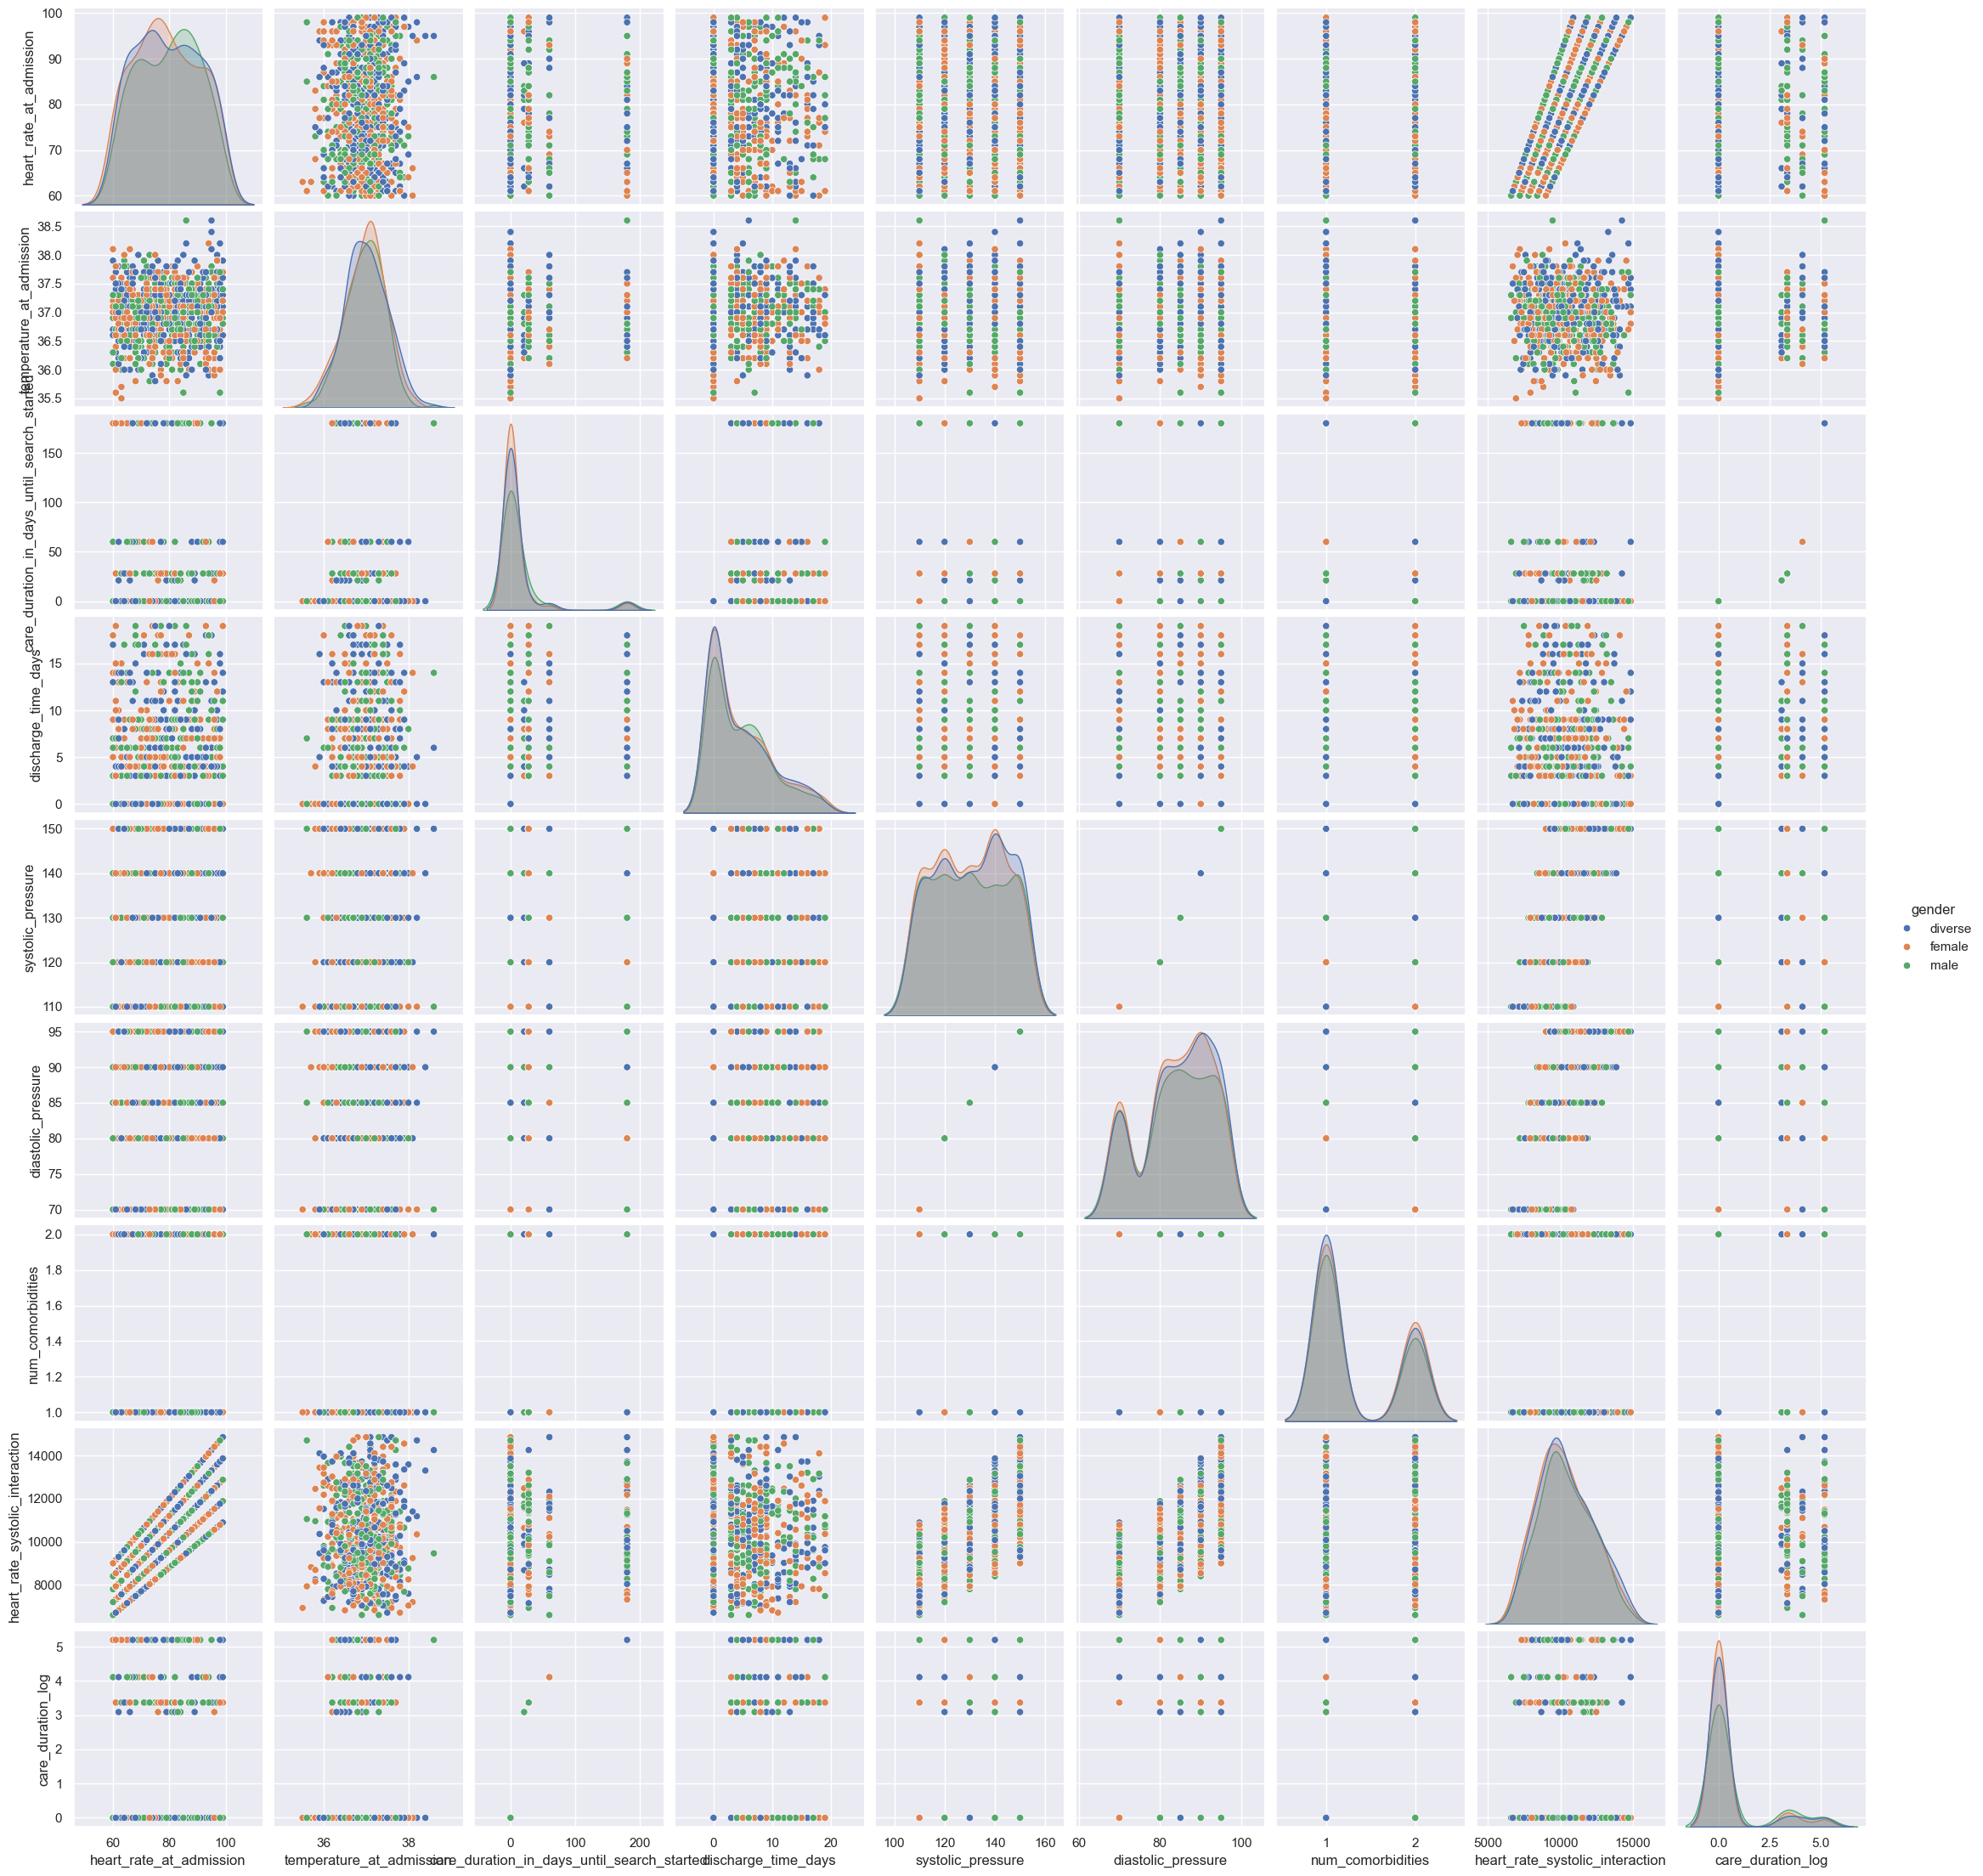

In [24]:
sns.pairplot(data=df, hue="gender")
plt.savefig('1.jpeg', format='jpeg', dpi=300)

### Total no discharge vs all other diagnoses. Hypotesis: there are more patients who don't need care than those who need some treatement. 

In [25]:
specific_value = 'no needed'

count_specific = (df['type_of_care_discharge_needed'] == specific_value).sum()
count_others = len(df) - count_specific

counts = [count_specific, count_others]
labels = ['No needed', 'Any type of care needed']

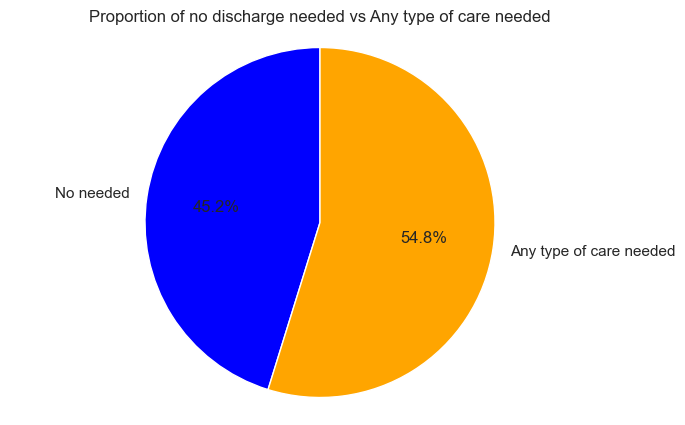

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(8, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange'])
plt.title(f'Proportion of no discharge needed vs Any type of care needed')
plt.axis('equal')
plt.show()

plt.savefig('2.jpeg', format='jpeg', dpi=300)

Conclusion: Rejected  - For this dataset most of the people require discharge

### Distribution of Discharge Time

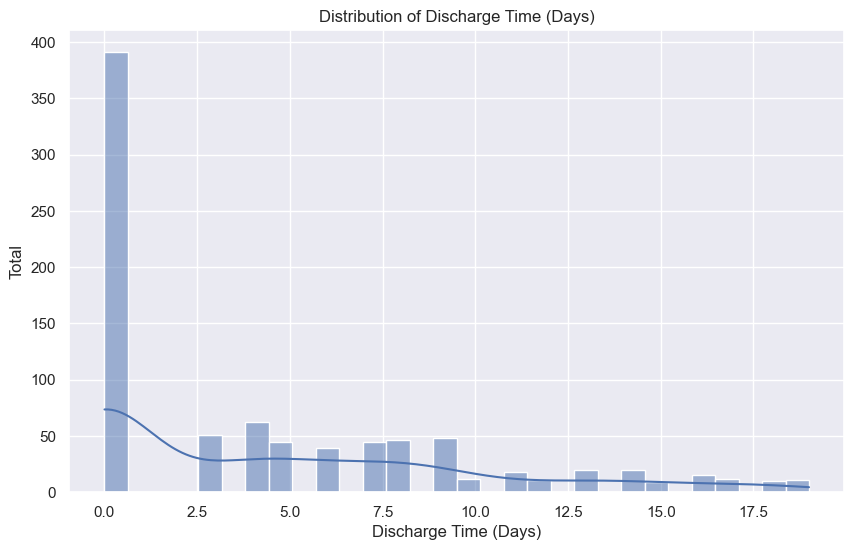

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['discharge_time_days'], bins=30, kde=True)
plt.title('Distribution of Discharge Time (Days)')
plt.xlabel('Discharge Time (Days)')
plt.ylabel('Total')

plt.savefig('imgs/3.jpeg', format='jpeg', dpi=300)
plt.show()

### Distribution of care_duration_in_days_until_search_started

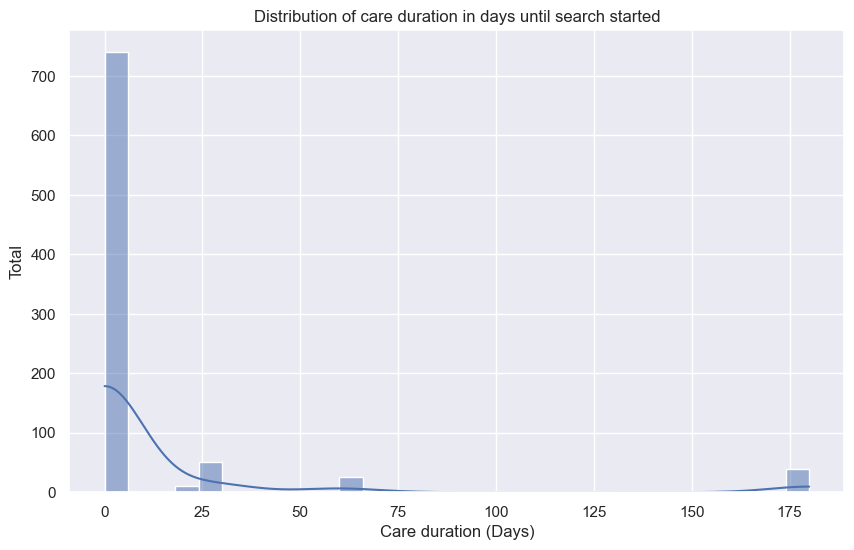

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['care_duration_in_days_until_search_started'], bins=30, kde=True)
plt.title('Distribution of care duration in days until search started')
plt.xlabel('Care duration (Days)')
plt.ylabel('Total')

plt.savefig('imgs/3.jpeg', format='jpeg', dpi=300)
plt.show()

### Total patientes by gender. Hypotesis: there are more female patients than diverse or male

/var/folders/pk/rxgl8mj51gjgh99rn254m6h00000gn/T/ipykernel_22228/881420049.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', palette='Set2', dodge=True)


Text(0, 0.5, 'Count')

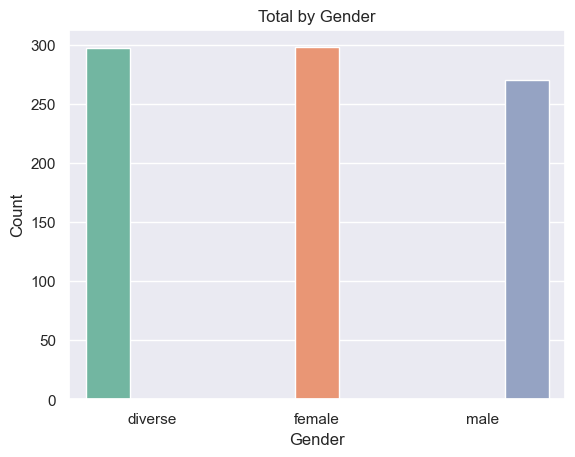

In [29]:
sns.countplot(data=df, x='gender', palette='Set2', dodge=True)
plt.title('Total by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

Conclusion: For those who require discharge, the biggest concentration is around 4 days.

### Count of Main diagnoses

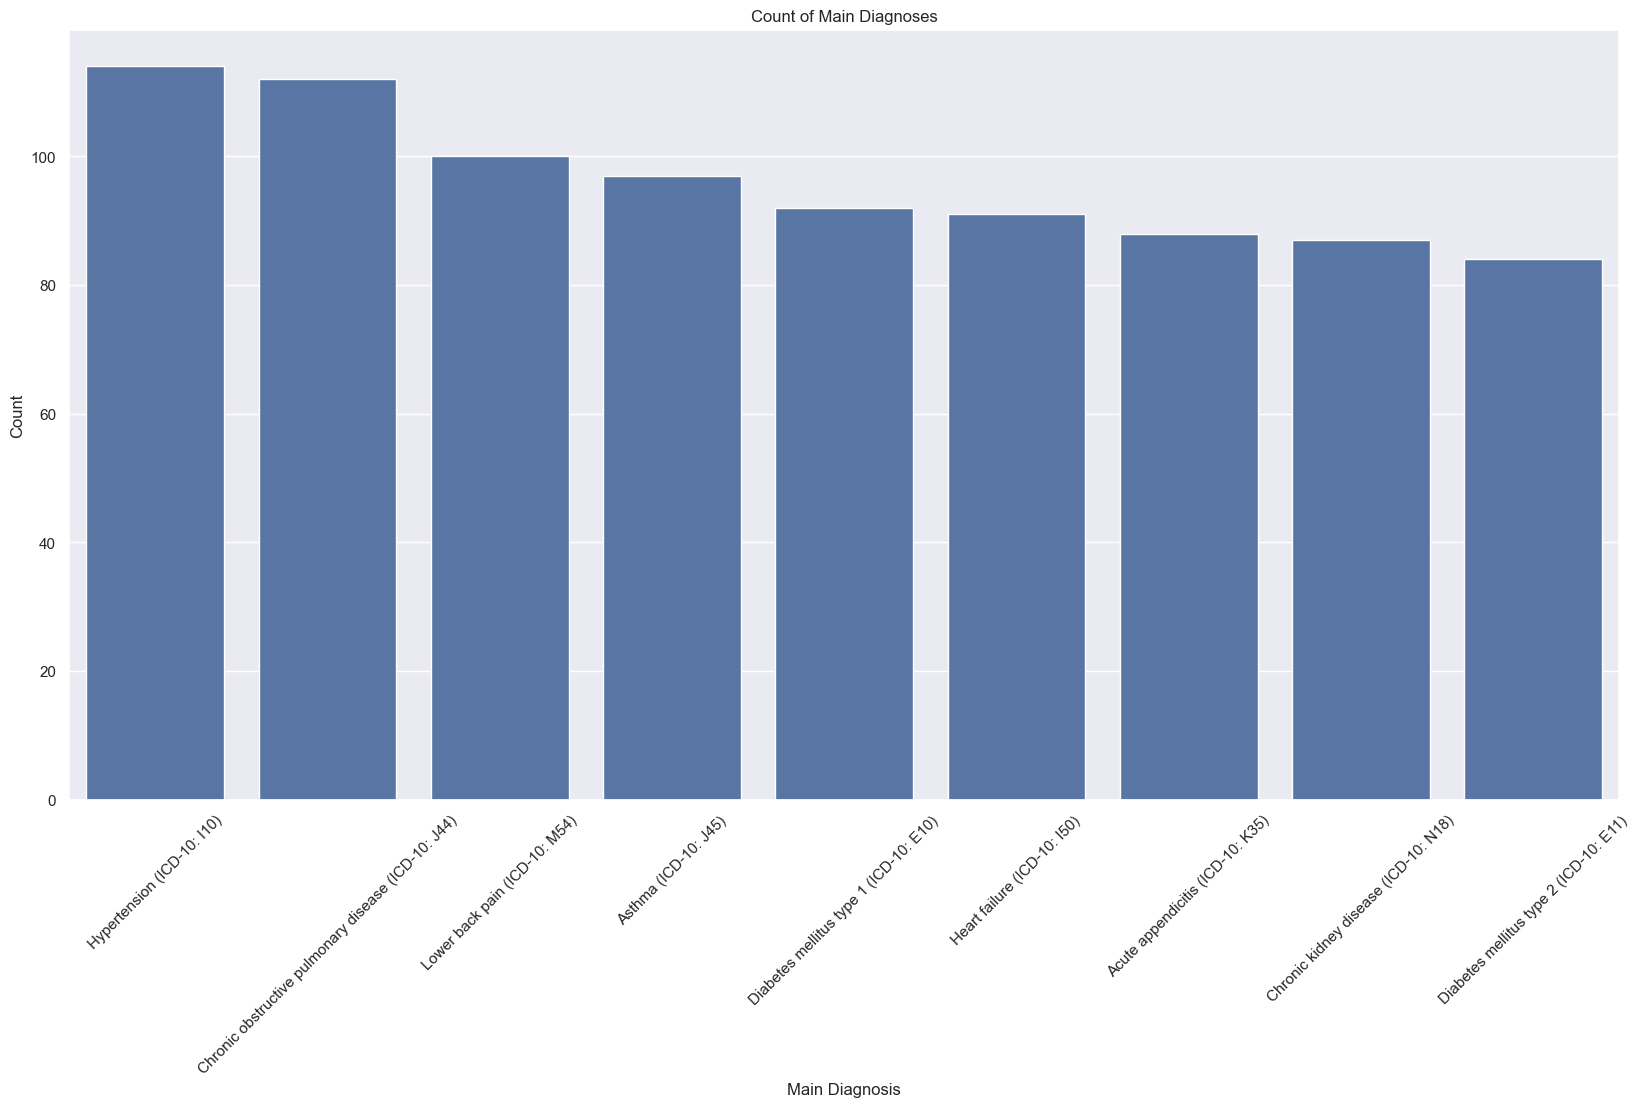

In [30]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(data=df, x='main_diagnosis', order=df['main_diagnosis'].value_counts().index)
plt.title('Count of Main Diagnoses')
plt.xticks(rotation=45)
plt.xlabel('Main Diagnosis')
plt.ylabel('Count')

plt.savefig('imgs/4.jpeg', format='jpeg', dpi=300)
plt.show()

### Count of care level - Hypotesis: Most of the pacients have low care levels. Rejected - Most of the pacients in among 3,4,5

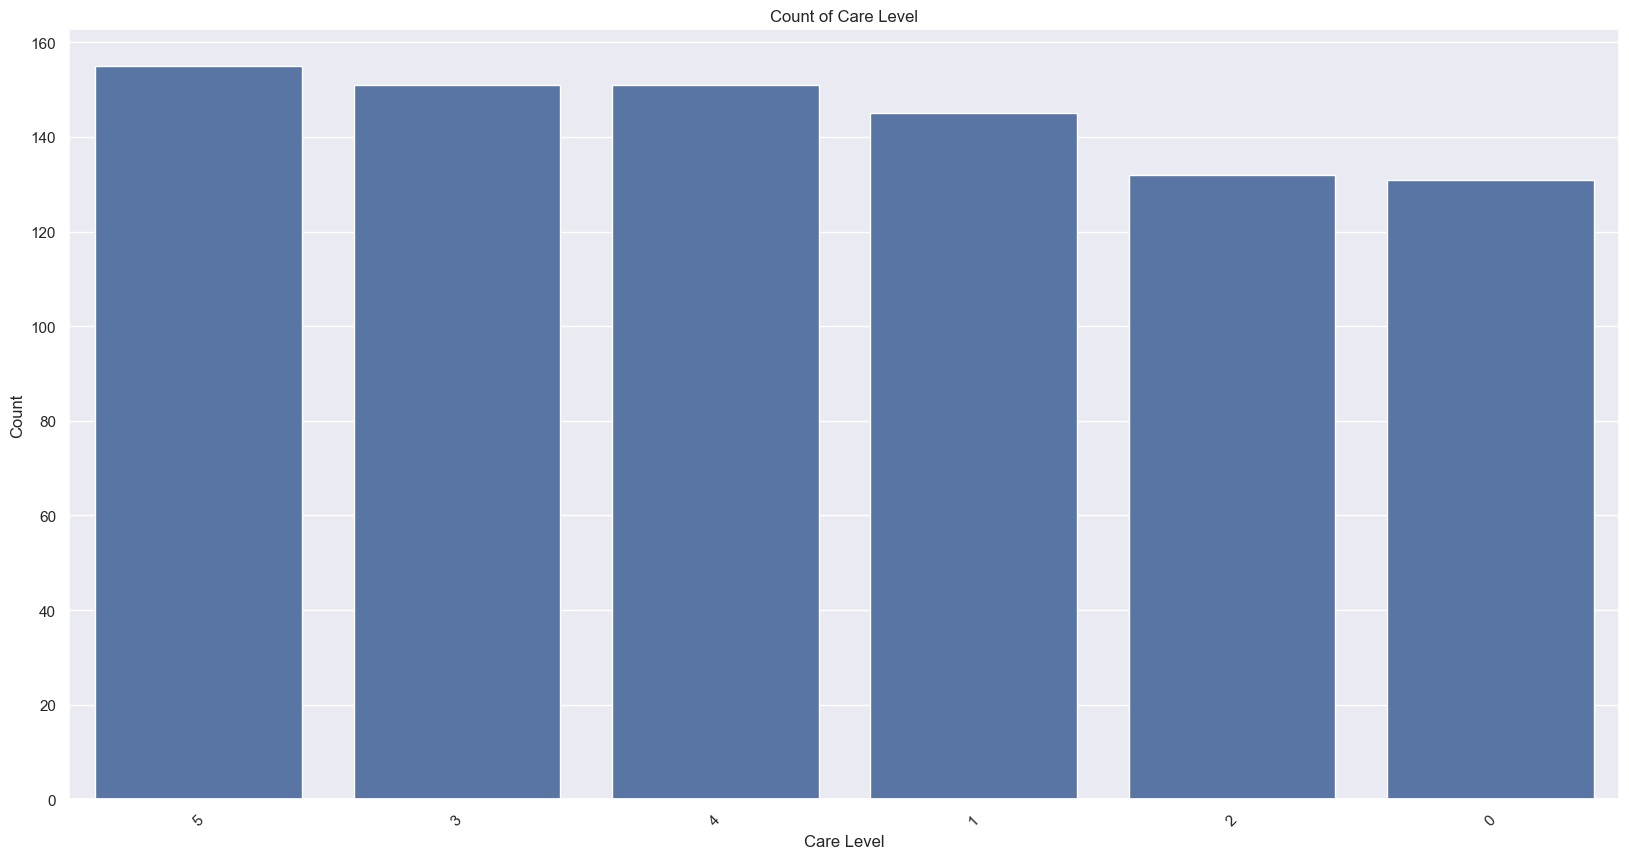

In [31]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(data=df, x='care_level', order=df['care_level'].value_counts().index)
plt.title('Count of Care Level')
plt.xticks(rotation=45)
plt.xlabel('Care Level')
plt.ylabel('Count')

#plt.savefig('imgs/4.jpeg', format='jpeg', dpi=300)
plt.show()


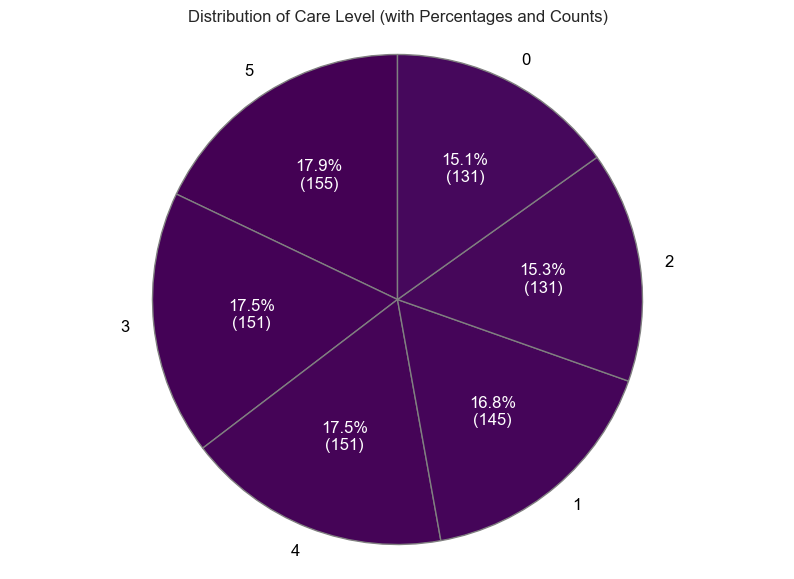

In [32]:
care_level_counts = df['care_level'].value_counts()

def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(10, 7))

wedges, texts, autotexts = plt.pie(care_level_counts, labels=care_level_counts.index, 
                                   autopct=lambda pct: func(pct, care_level_counts), 
                                   startangle=90, colors=plt.cm.viridis.colors, 
                                   textprops={'fontsize': 12, 'color': 'black'},  # Text for category labels
                                   wedgeprops={'edgecolor': 'gray'}, 
                                   labeldistance=1.1)  # Move labels further from the center

for autotext in autotexts:
    autotext.set_color('white')  # Set the color of the percentage text
    autotext.set_fontsize(12)  # Adjust the font size of the percentage text

for text in texts:
    text.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6))  # Adds background padding

plt.title('Distribution of Care Level (with Percentages and Counts)')
plt.axis('equal')

# Show the plot
plt.show()

### Count of co-morbidities

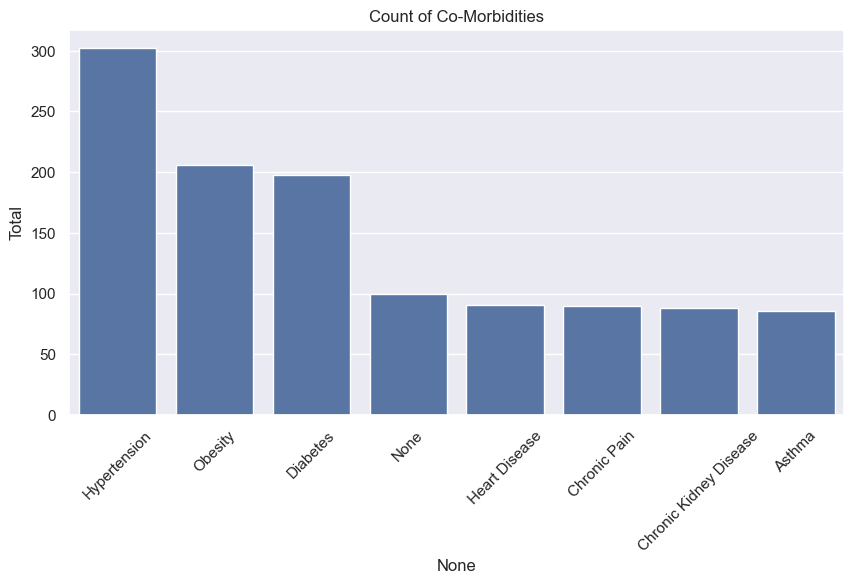

In [33]:
co_morbidity_counts = df['co_morbidities'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)
co_morbidity_counts = co_morbidity_counts[co_morbidity_counts > 0]

plt.figure(figsize=(10, 5))
sns.barplot(x=co_morbidity_counts.index, y=co_morbidity_counts.values)
plt.title('Count of Co-Morbidities')
plt.xticks(rotation=45)
plt.ylabel('Total')

plt.savefig('imgs/12.jpeg', format='jpeg', dpi=300)
plt.show()

### Types of Care Discharge Needed

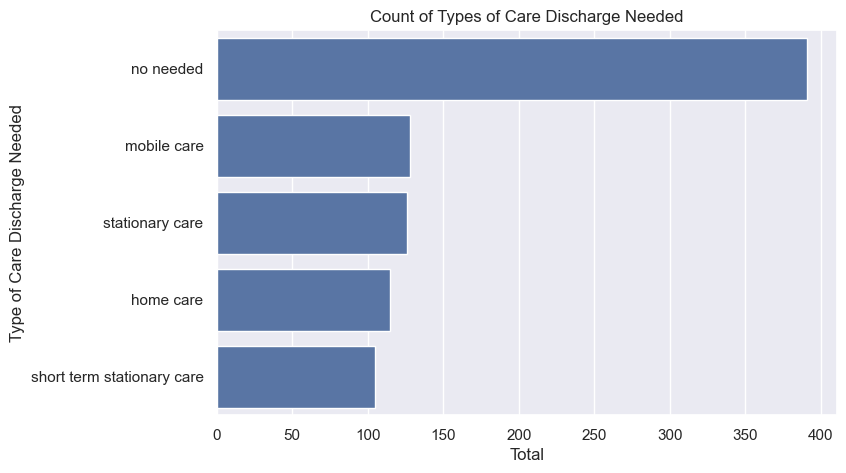

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(y='type_of_care_discharge_needed', data=df, order=df['type_of_care_discharge_needed'].value_counts().index)
plt.title('Count of Types of Care Discharge Needed')
plt.xlabel('Total')
plt.ylabel('Type of Care Discharge Needed')

plt.savefig('imgs/8.jpeg', format='jpeg', dpi=300)
plt.show()

### Relationship between numerical features

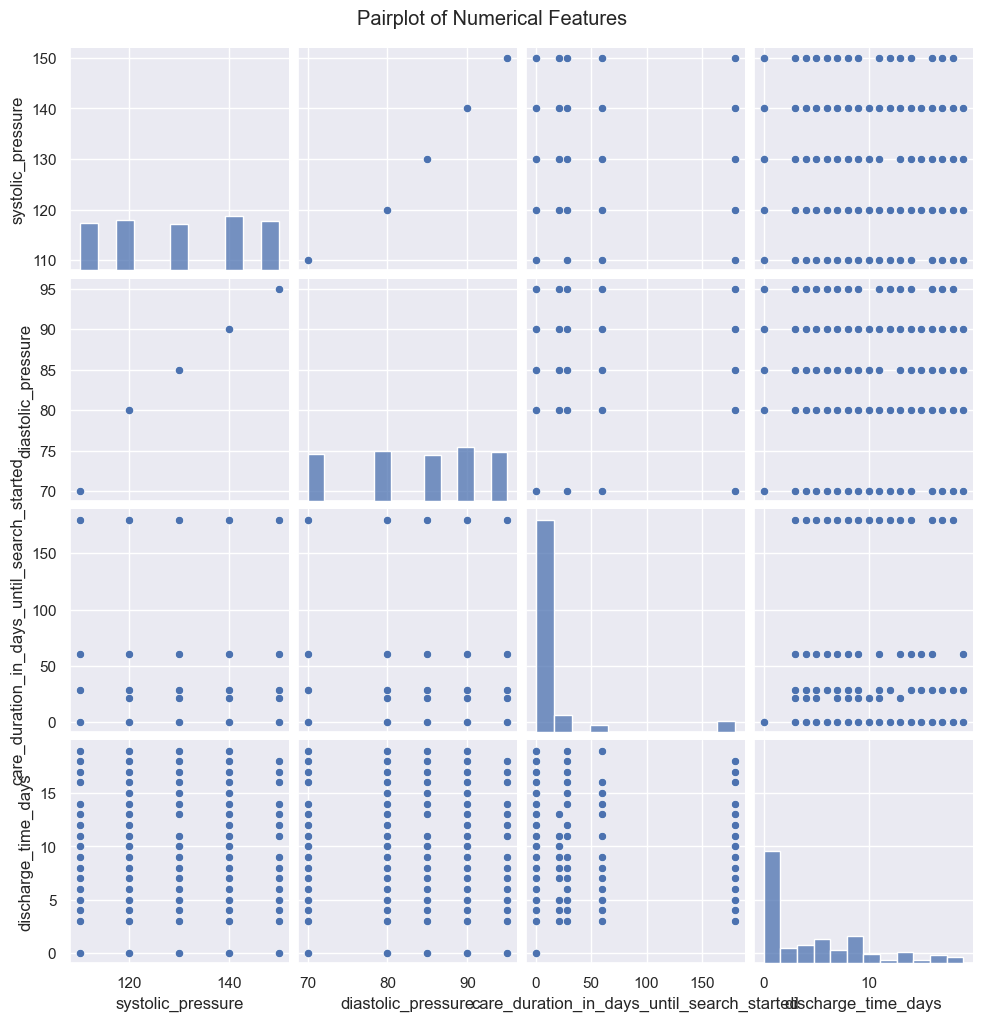

In [35]:
numerical_features = ['systolic_pressure', 'diastolic_pressure', 'care_duration_in_days_until_search_started', 'discharge_time_days']
sns.pairplot(df[numerical_features])
plt.suptitle('Pairplot of Numerical Features', y=1.02)

plt.savefig('imgs/9.jpeg', format='jpeg', dpi=300)
plt.show()

### Violin plot care level vs discharge time

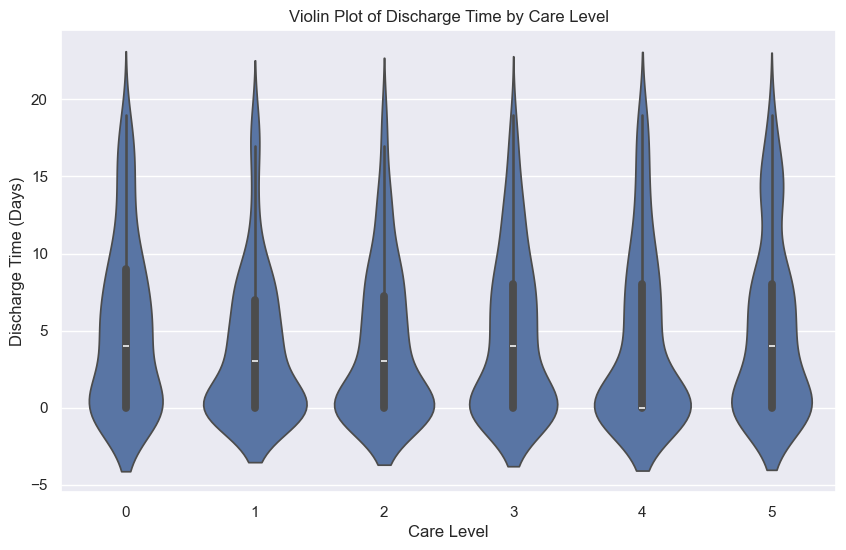

In [36]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='care_level', y='discharge_time_days', data=df.sort_values(by="care_level"))
plt.title('Violin Plot of Discharge Time by Care Level')
plt.ylabel('Discharge Time (Days)')
plt.xlabel('Care Level')

plt.savefig('imgs/11.jpeg', format='jpeg', dpi=300)
plt.show()

### Quick analysis discharge time by diagnosis

/var/folders/pk/rxgl8mj51gjgh99rn254m6h00000gn/T/ipykernel_22228/3678882421.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_discharge_times = df.groupby('main_diagnosis')['discharge_time_days'].mean().reset_index()
/var/folders/pk/rxgl8mj51gjgh99rn254m6h00000gn/T/ipykernel_22228/3678882421.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='main_diagnosis', y='discharge_time_days', data=mean_discharge_times, palette='viridis')


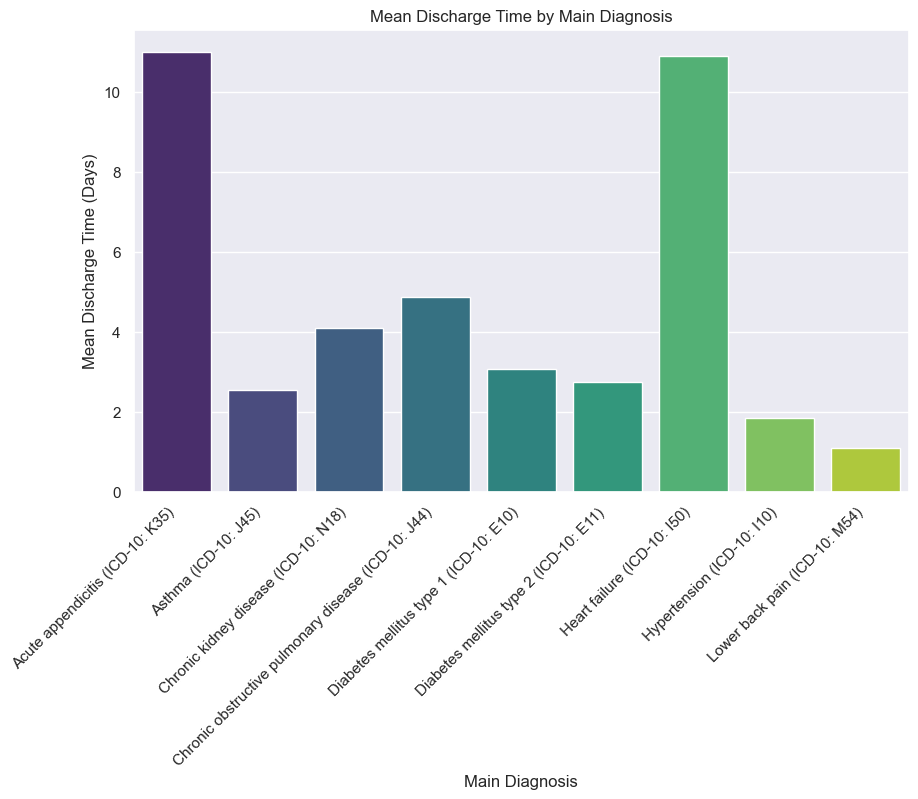

In [37]:
mean_discharge_times = df.groupby('main_diagnosis')['discharge_time_days'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='main_diagnosis', y='discharge_time_days', data=mean_discharge_times, palette='viridis')
plt.title('Mean Discharge Time by Main Diagnosis')
plt.xlabel('Main Diagnosis')
plt.ylabel('Mean Discharge Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.show()

### Discharge Time by Main Diagnosis

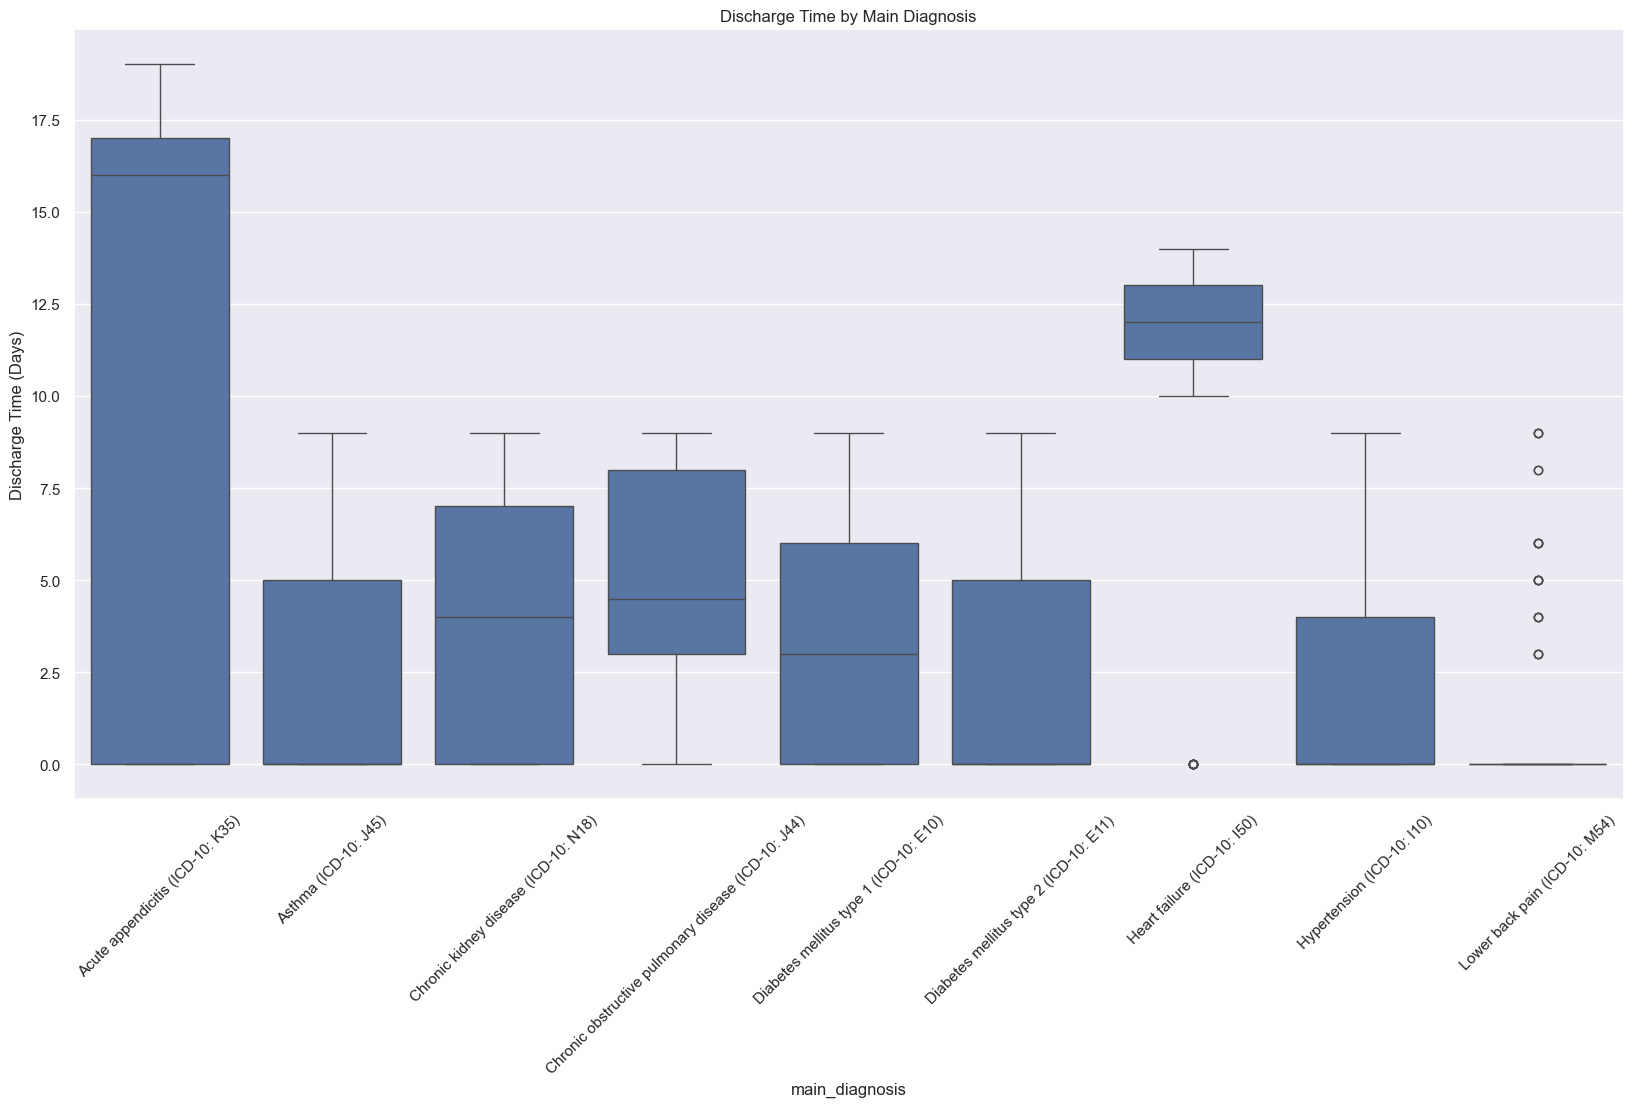

In [38]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.boxplot(x='main_diagnosis', y='discharge_time_days', data=df)
plt.title('Discharge Time by Main Diagnosis')
plt.xticks(rotation=45)
plt.ylabel('Discharge Time (Days)')
plt.savefig('imgs/5.jpeg', format='jpeg', dpi=300)
plt.show()

Conclusion: most of the people that take long periods of discharge suffer of appendicitis. There is a very small probability that lower back pian requires discharge.

### Relationship between main diagnosis and care level - Hypotesis appendeicitis has the highest care level

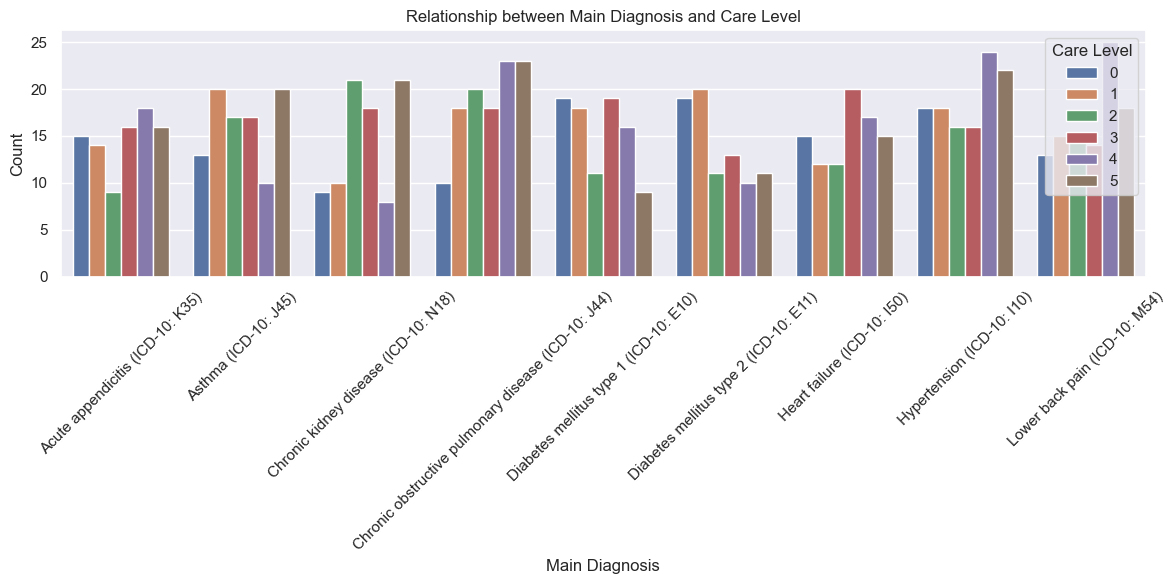

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='main_diagnosis', hue='care_level')
plt.title('Relationship between Main Diagnosis and Care Level')
plt.xticks(rotation=45)
plt.xlabel('Main Diagnosis')
plt.ylabel('Count')
plt.legend(title='Care Level')
plt.tight_layout()

plt.savefig('imgs/6.jpeg', format='jpeg', dpi=300)
plt.show()

Conclusion: Chronic obstructive pulmonary disease has the higher care level (5)

### Relationship between main diagnosis and care leve (stack)

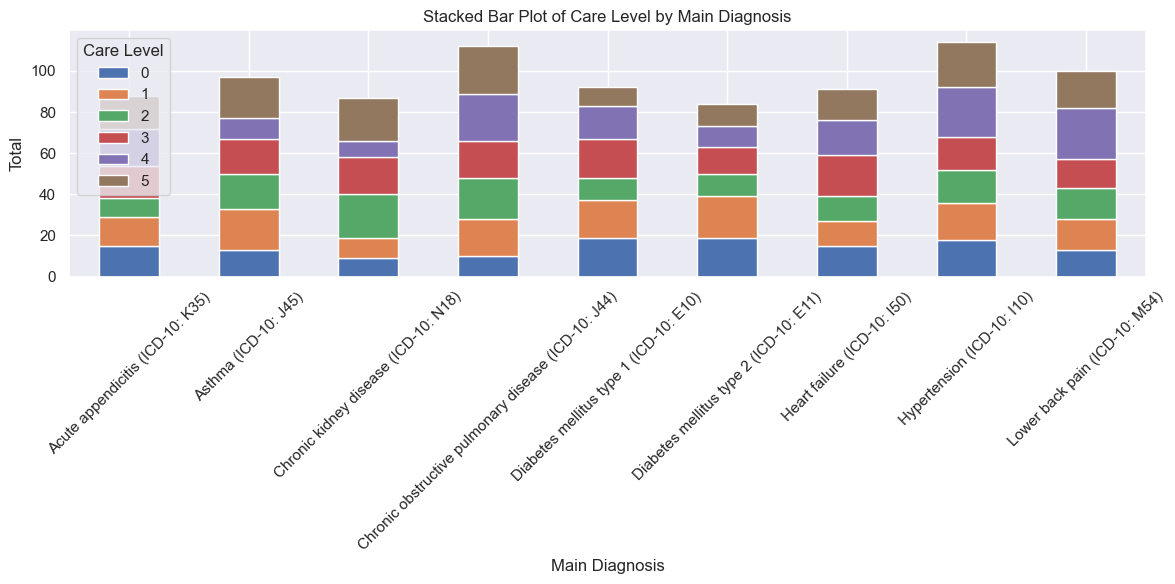

In [40]:
contingency_table = pd.crosstab(df['main_diagnosis'], df['care_level'])

contingency_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Plot of Care Level by Main Diagnosis')
plt.ylabel('Total')
plt.xlabel('Main Diagnosis')
plt.xticks(rotation=45)
plt.legend(title='Care Level')
plt.tight_layout()

plt.savefig('imgs/7.jpeg', format='jpeg', dpi=300)
plt.show()

Conclusion: stationary, mobile and care have almost the same distribution

### Discharge Time by Gender and Mobility

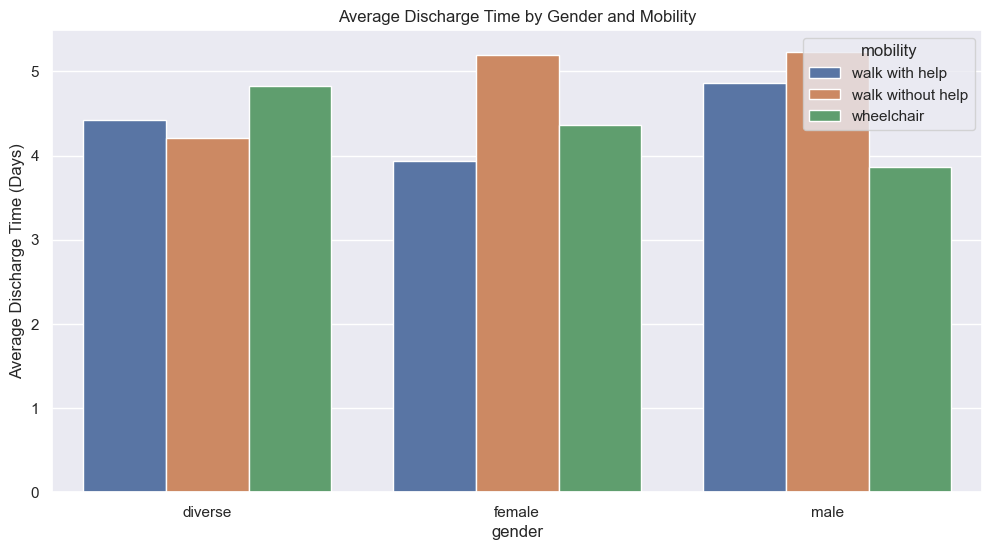

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(x='gender', y='discharge_time_days', hue='mobility', data=df, errorbar=None)
plt.title('Average Discharge Time by Gender and Mobility')
plt.ylabel('Average Discharge Time (Days)')

plt.savefig('imgs/10.jpeg', format='jpeg', dpi=300)
plt.show()


Conclusion: Diverse genders tend to need some kind of help

Note: It's worth it to understand why are unknown care levels, then decide how to interpret/process it

### Care level by gender

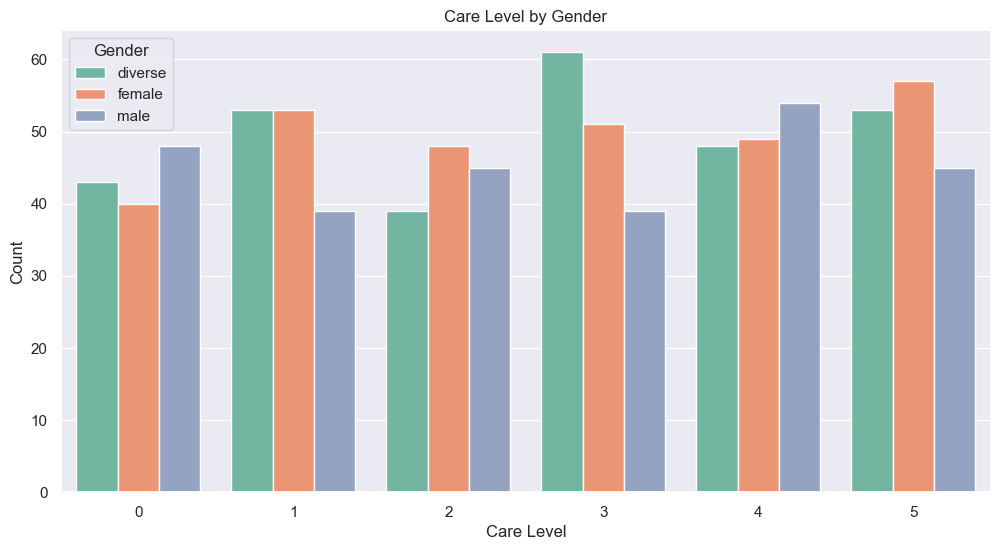

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='care_level', hue='gender', palette='Set2', dodge=True)
plt.title('Care Level by Gender')
plt.xlabel('Care Level')
plt.ylabel('Count')
plt.legend(title='Gender')

plt.savefig('imgs/13.jpeg', format='jpeg', dpi=300)
plt.show()

### Correlation of numerical variables - Hypotesis: There is a correlation between discharge_time_days and care_duration_in_days_until_search_started

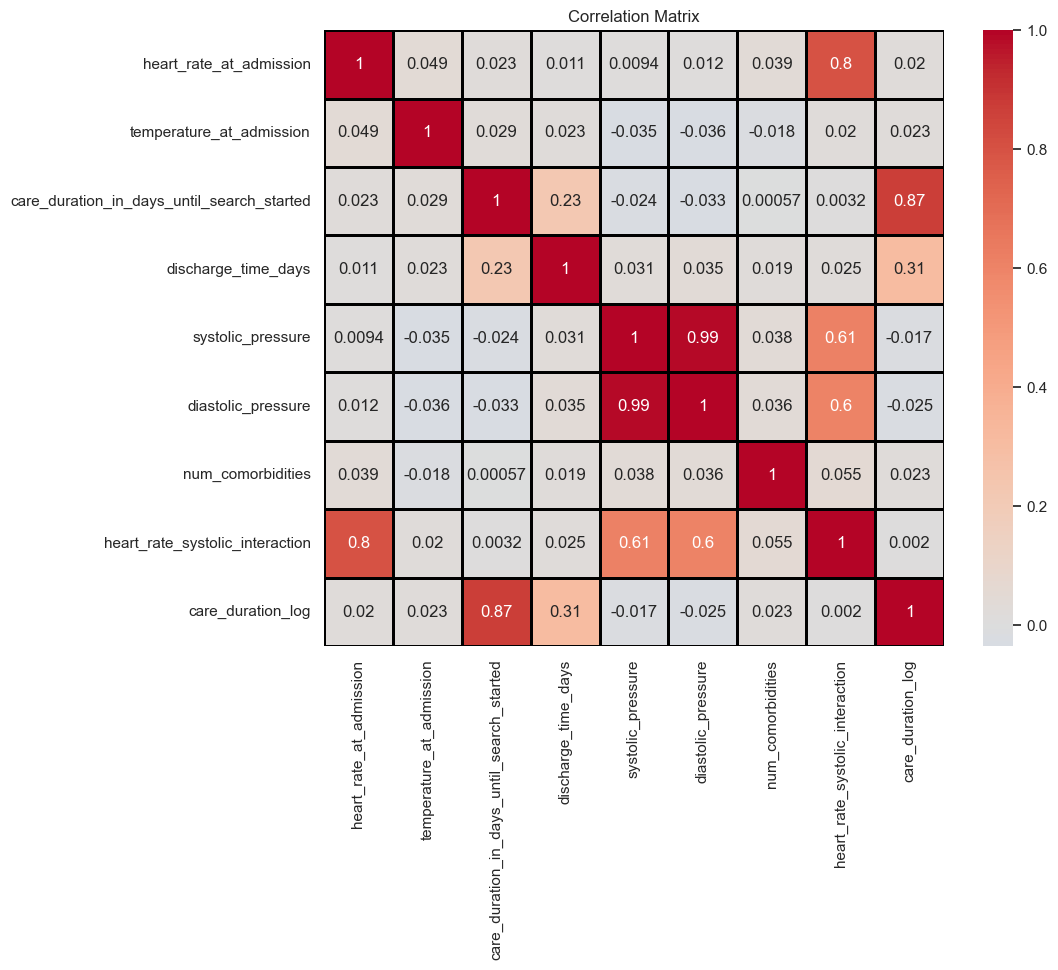

In [43]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

corr = numerical_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=1, linecolor='black')

plt.title('Correlation Matrix')

plt.show()

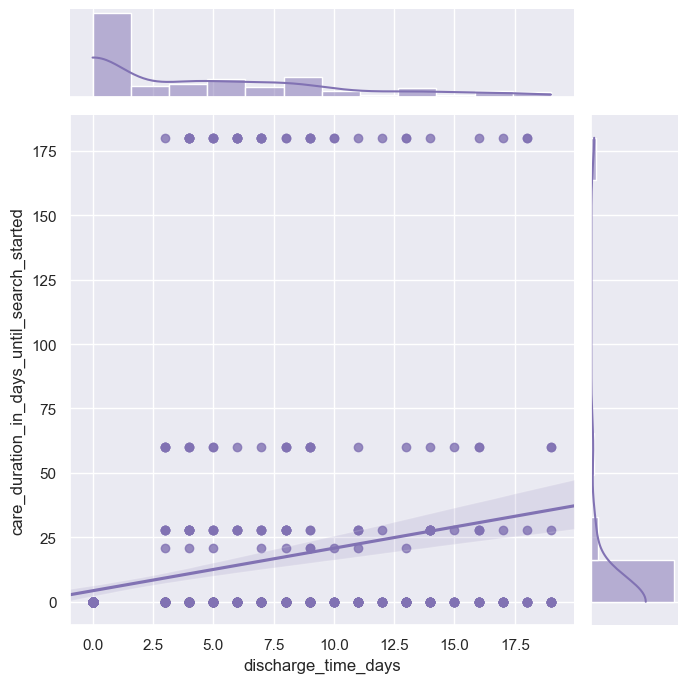

In [44]:
sns.jointplot(x="discharge_time_days", y="care_duration_in_days_until_search_started", data=df,
                  kind="reg", truncate=False,
                  color="m", height=7)

### Average discharge time by care level

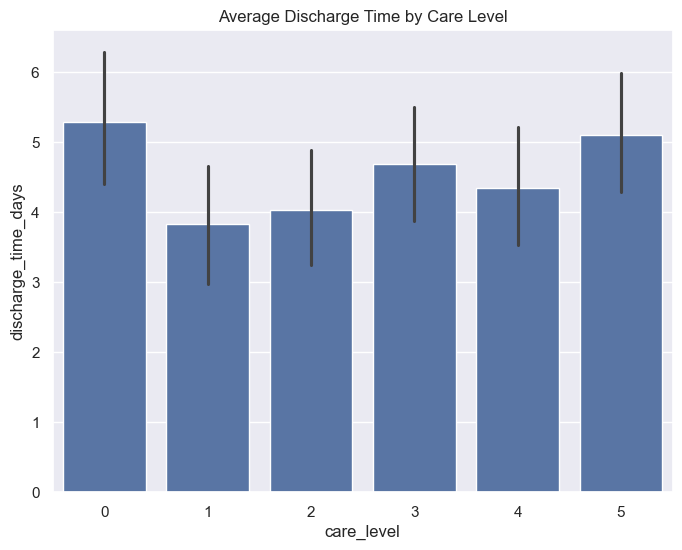

In [45]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='care_level', y='discharge_time_days')
plt.title('Average Discharge Time by Care Level')
plt.show()

### Heart rate at admission is related to the main diagnosis

<Axes: xlabel='main_diagnosis', ylabel='heart_rate_at_admission'>

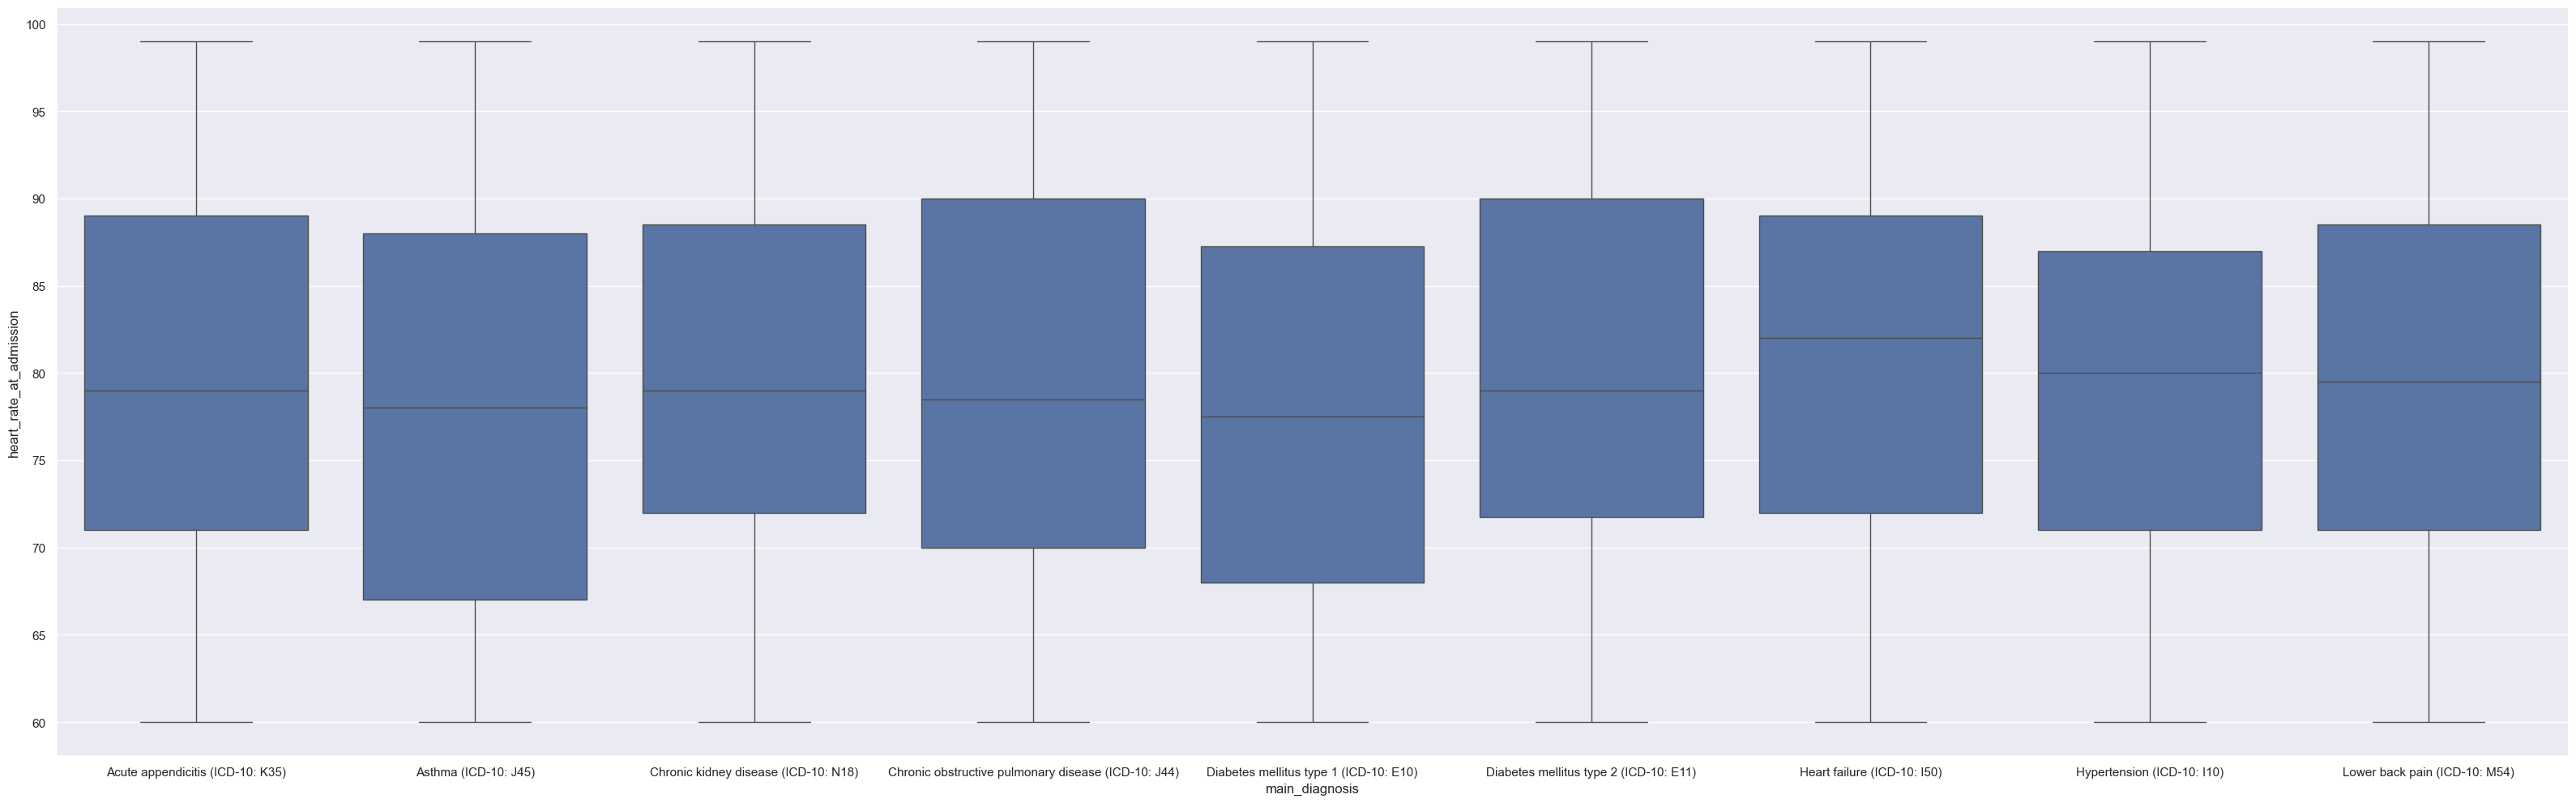

In [46]:
plt.figure(figsize=(40, 12))
sns.boxplot(data=df, x='main_diagnosis', y='heart_rate_at_admission')


Conclusion: heart failure has a direct impact in bpms

### Co-morbidities are related to the care level

<Axes: xlabel='care_level', ylabel='count'>

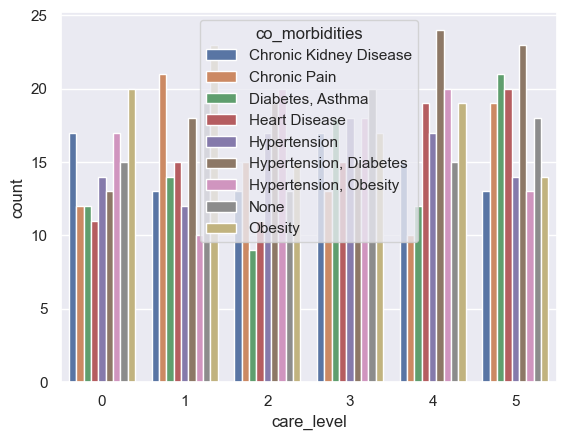

In [47]:
sns.countplot(data=df, x='care_level', hue='co_morbidities')

### Correlation between mobility and discharge time days

<Axes: xlabel='mobility', ylabel='discharge_time_days'>

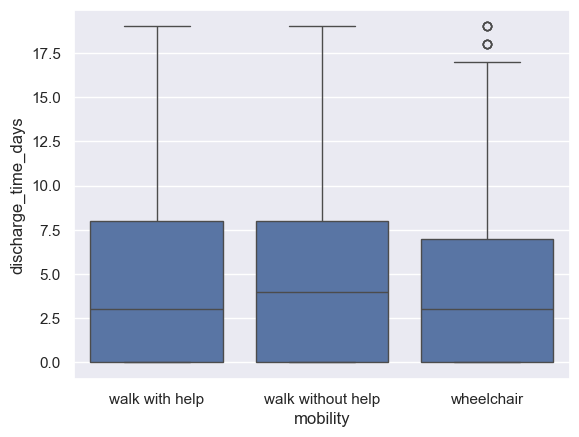

In [48]:
sns.boxplot(data=df, x='mobility', y='discharge_time_days')

<Axes: xlabel='main_diagnosis', ylabel='temperature_at_admission'>

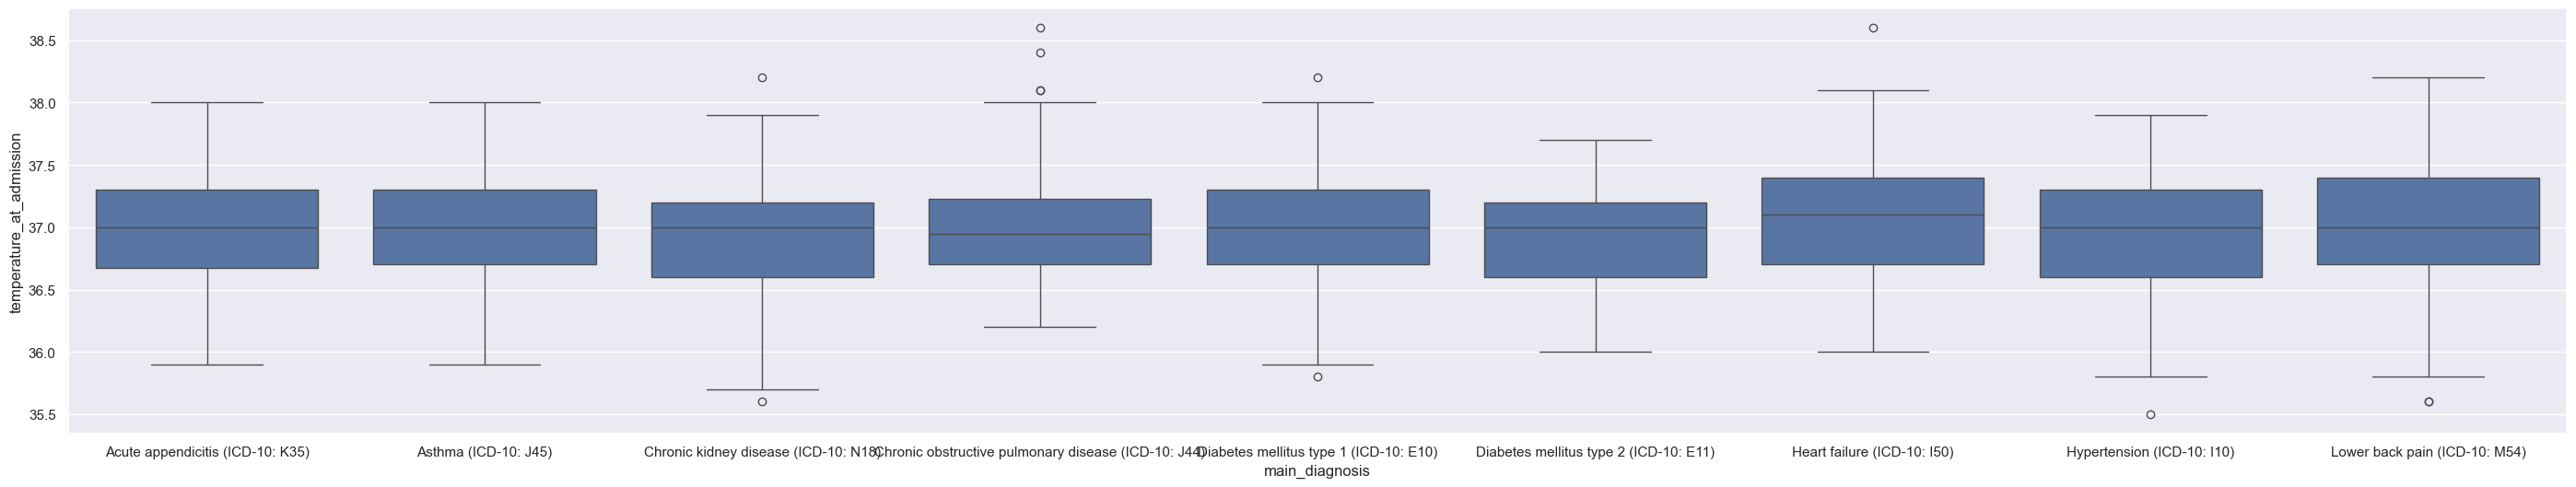

In [49]:
plt.figure(figsize=(35, 6))
sns.boxplot(data=df, x='main_diagnosis', y='temperature_at_admission')

### Hypothesis: Patients requiring stationary care or mobile care may have longer discharge times than those with no further care needed.

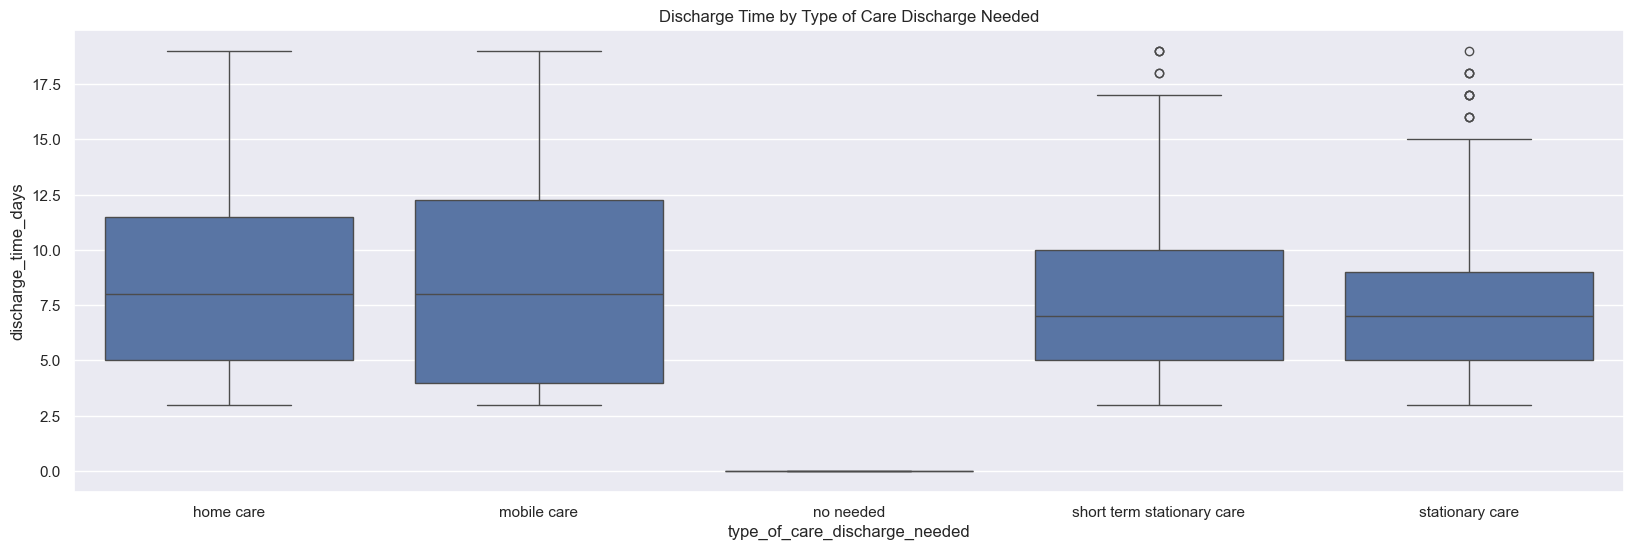

In [50]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='type_of_care_discharge_needed', y='discharge_time_days')
plt.title('Discharge Time by Type of Care Discharge Needed')
plt.show()

### Hypothesis: Patients with higher care levels (more complex care) may have longer discharge times. Rejected. 0 and 5 have almost the same discharge time days

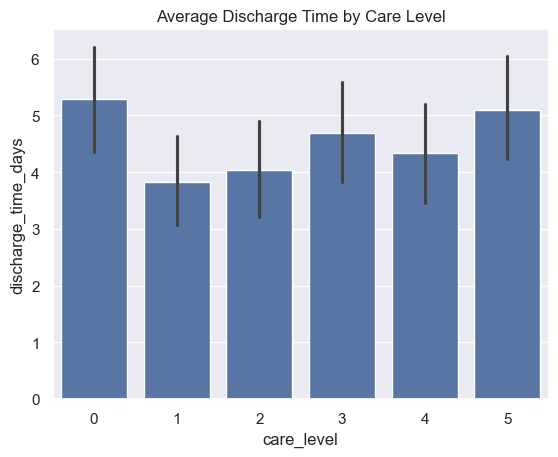

In [51]:
sns.barplot(data=df, x='care_level', y='discharge_time_days')
plt.title('Average Discharge Time by Care Level')
plt.show()

### Hypothesis: Patients with lower mobility (e.g., those requiring assistance) may have longer hospital stays. Reject. Walk without help has the highest avg

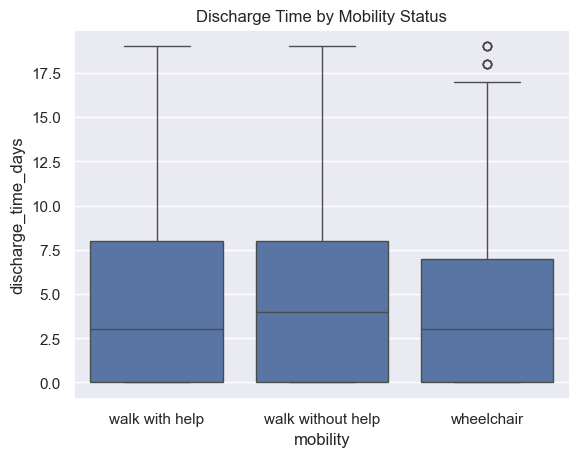

In [52]:
sns.boxplot(data=df, x='mobility', y='discharge_time_days')
plt.title('Discharge Time by Mobility Status')
plt.show()

### Hypothesis: Patients with certain co-morbidities (e.g., diabetes, hypertension) may have prolonged hospital stays due to more complex health issues.

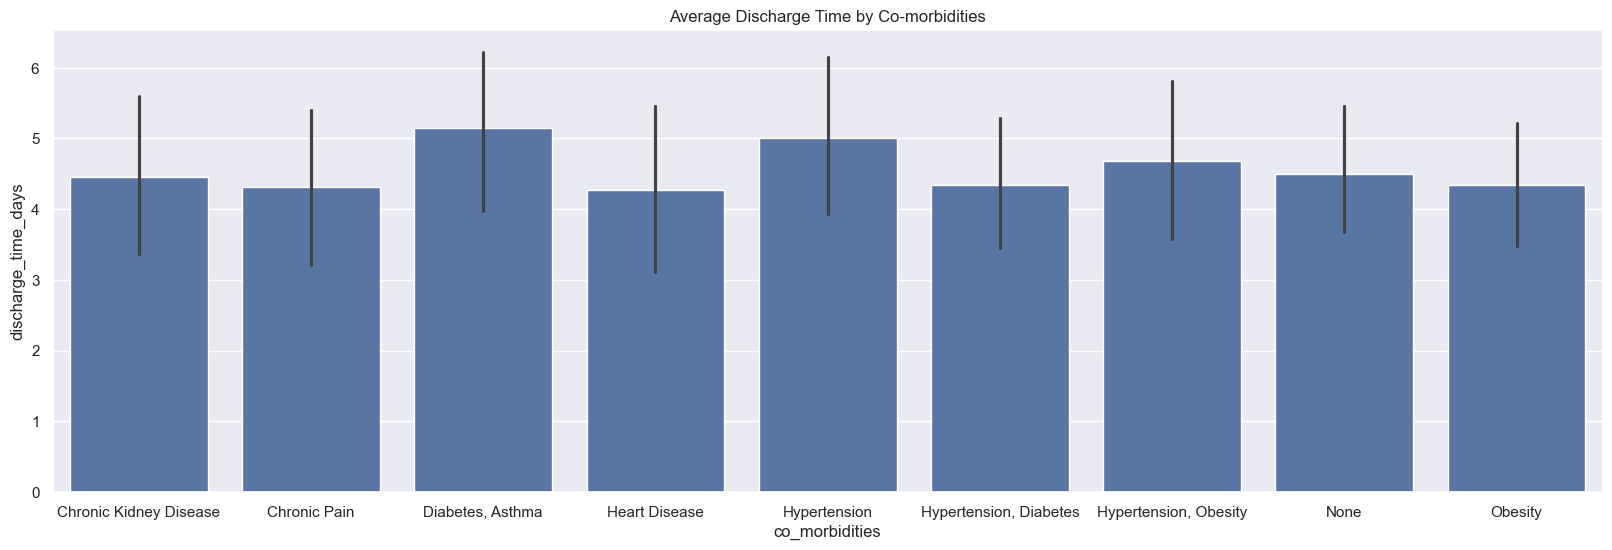

In [53]:
plt.figure(figsize=(20, 6))
sns.barplot(data=df, x='co_morbidities', y='discharge_time_days')
plt.title('Average Discharge Time by Co-morbidities')
plt.show()

Heart disease and chronic pain have lower probability

### Hypothesis: Elevated temperature (e.g., fever) at admission could be indicative of more serious conditions, leading to longer discharge times.

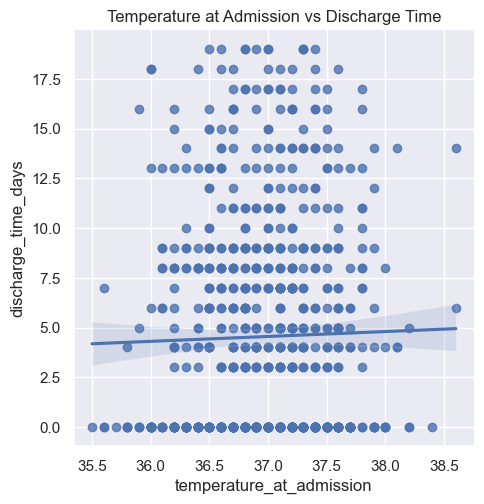

In [54]:
sns.lmplot(data=df, x='temperature_at_admission', y='discharge_time_days')
plt.title('Temperature at Admission vs Discharge Time')
plt.show()

Conclusion: Between 36 and 37.5 , there is higher probability to have a discharge time of 5<= X< 9 and 12.5<=X <=15

### Hypothesis: Some types of care discharge requires more days until search starts and that impacts in the discharge time

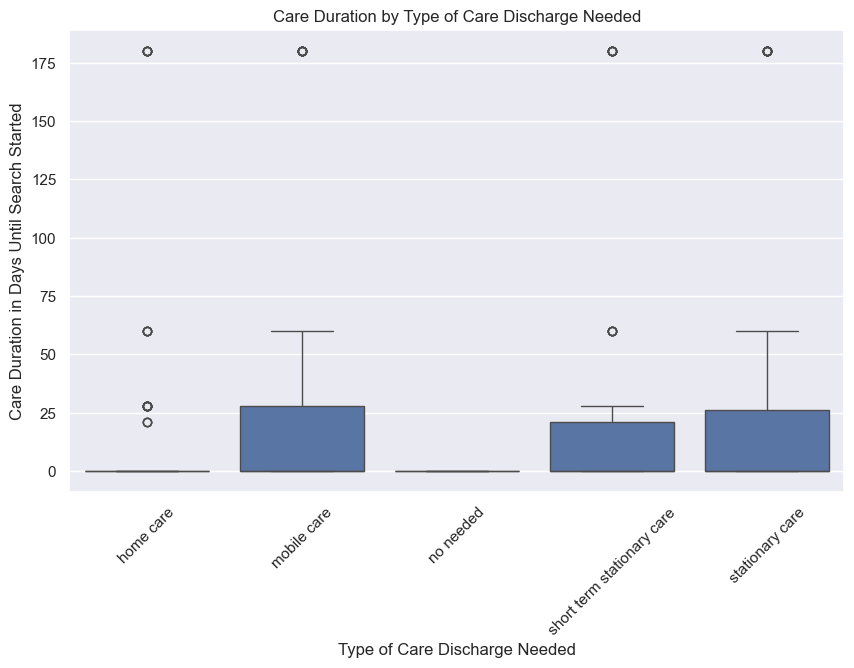

In [55]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='type_of_care_discharge_needed', y='care_duration_in_days_until_search_started')

plt.title('Care Duration by Type of Care Discharge Needed')
plt.xlabel('Type of Care Discharge Needed')
plt.ylabel('Care Duration in Days Until Search Started')
plt.xticks(rotation=45)

plt.show()

### Total average duration of patient in the hospital by type of care needed

/var/folders/pk/rxgl8mj51gjgh99rn254m6h00000gn/T/ipykernel_22228/1689971120.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='type_of_care_discharge_needed', y='total_care_duration', estimator='mean', ci=None)


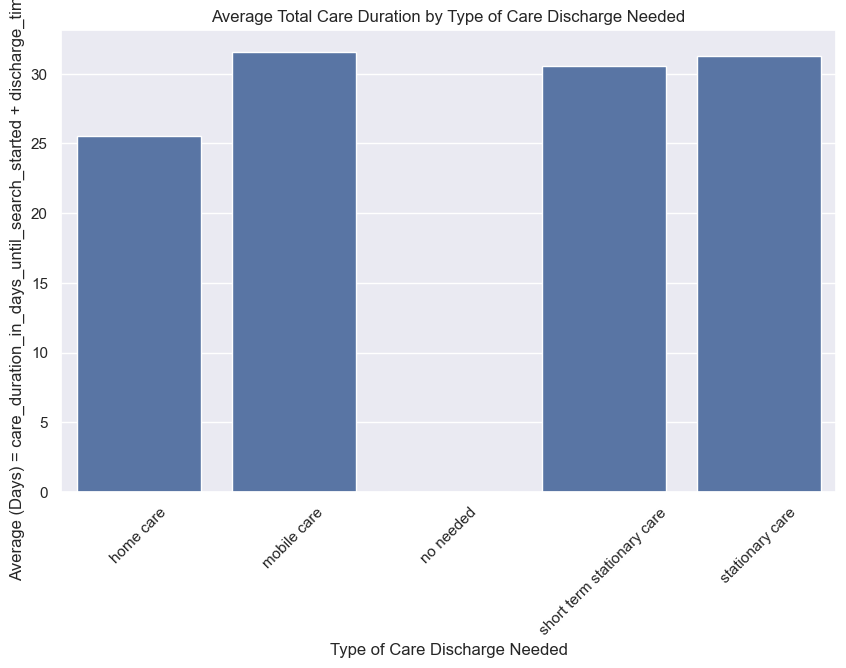

In [56]:
df['total_care_duration'] = df['care_duration_in_days_until_search_started'] + df['discharge_time_days']

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='type_of_care_discharge_needed', y='total_care_duration', estimator='mean', ci=None)

plt.title('Average Total Care Duration by Type of Care Discharge Needed')
plt.xlabel('Type of Care Discharge Needed')
plt.ylabel('Average (Days) = care_duration_in_days_until_search_started + discharge_time_days')
plt.xticks(rotation=45)

plt.show()

### Count of Co-morbidities by Care Level

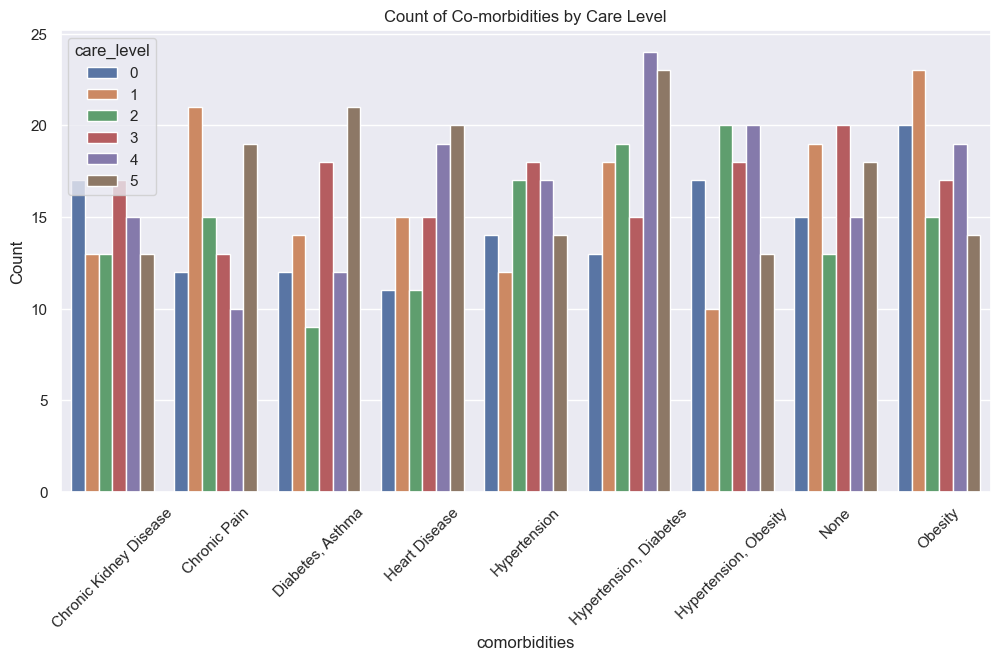

In [57]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='co_morbidities', hue='care_level')

# Customize the plot
plt.title('Count of Co-morbidities by Care Level')
plt.xlabel('comorbidities')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

### Count of Co-morbidities by Gender

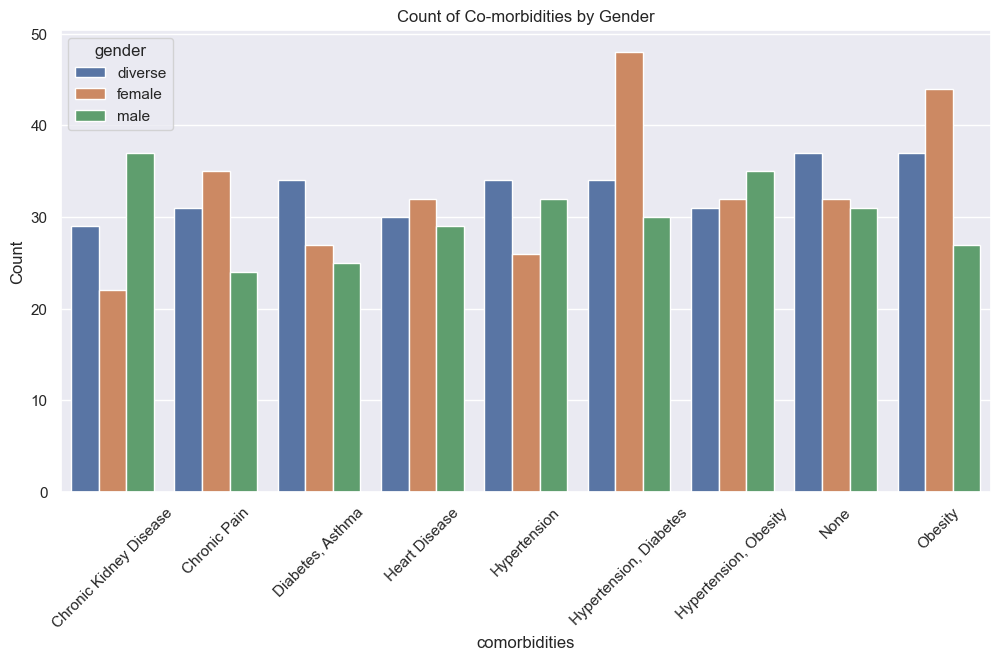

In [58]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='co_morbidities', hue='gender')

# Customize the plot
plt.title('Count of Co-morbidities by Gender')
plt.xlabel('comorbidities')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

### Count of Main diagnosis by Gender

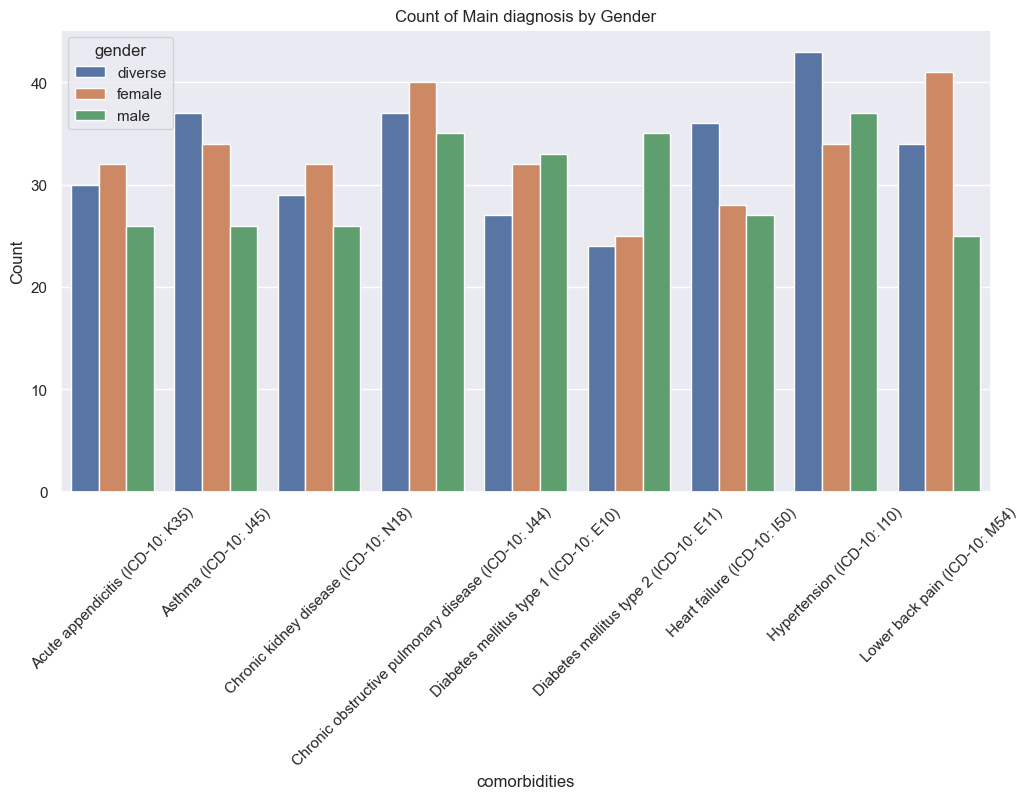

In [59]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='main_diagnosis', hue='gender')

# Customize the plot
plt.title('Count of Main diagnosis by Gender')
plt.xlabel('comorbidities')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

### Heatmap of Co-morbidities by Main Diagnosis

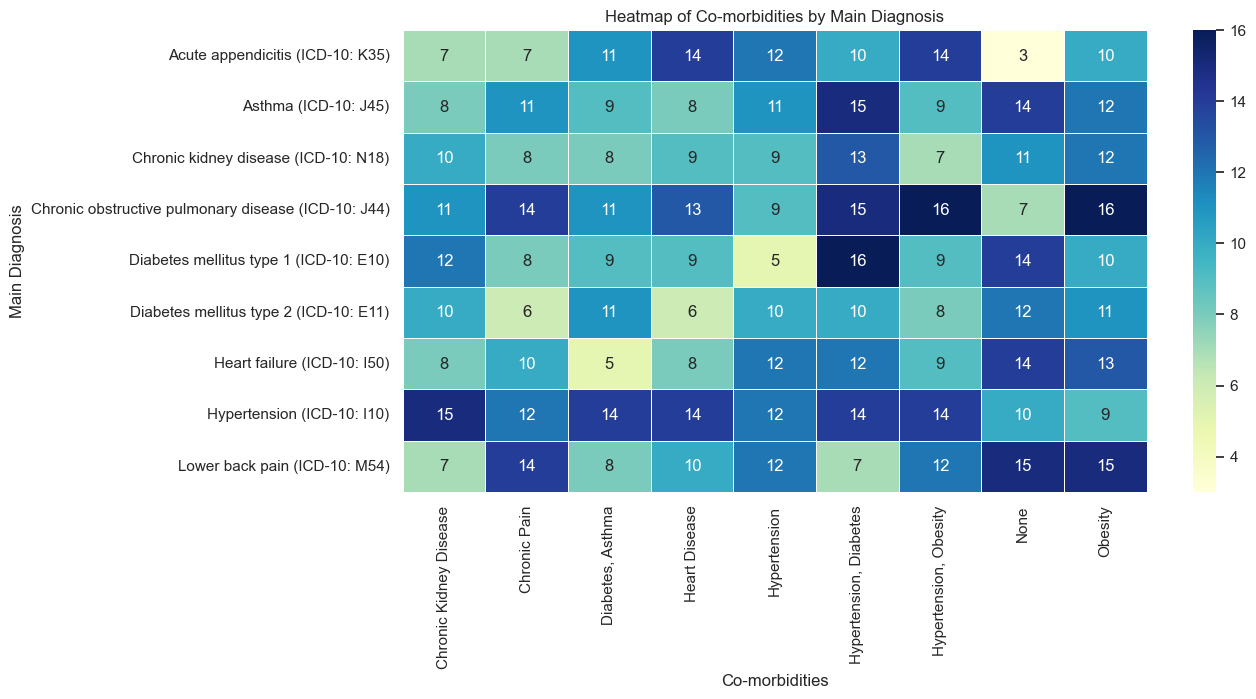

In [60]:
cross_tab = pd.crosstab(df['main_diagnosis'], df['co_morbidities'])

plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", linewidths=.5)

plt.title('Heatmap of Co-morbidities by Main Diagnosis')
plt.xlabel('Co-morbidities')
plt.ylabel('Main Diagnosis')

plt.show()